In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 40
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_JointEntropy_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortRunLowGrayLevelEmphasis_glrlm_ShortRunHighGrayLevelEmphasis_glrlm_LongRunLowGrayLevelEmphasis_glrlm_LongRunHighGrayLevelEmphasis_ngtdm_Coarseness_ngtdm_

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 468)
(3944610, 8)
validation
(464344, 468)
(464344, 8)
test
(574820, 468)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 468)]             0         


 dense (Dense)               (None, 1024)              480256    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1170312 (4.46 MB)


Trainable params: 1170312 (4.46 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 10:44 - loss: 2.3670 - STD: 0.0814 - MAE: 0.2205

  4/395 [..............................] - ETA: 6s - loss: 2.1667 - STD: 0.0540 - MAE: 0.2180   

  8/395 [..............................] - ETA: 6s - loss: 2.1272 - STD: 0.0569 - MAE: 0.2167

 12/395 [..............................] - ETA: 6s - loss: 2.1087 - STD: 0.0508 - MAE: 0.2167

 16/395 [>.............................] - ETA: 6s - loss: 2.0958 - STD: 0.0460 - MAE: 0.2168

 19/395 [>.............................] - ETA: 6s - loss: 2.0894 - STD: 0.0437 - MAE: 0.2168

 23/395 [>.............................] - ETA: 6s - loss: 2.0836 - STD: 0.0421 - MAE: 0.2167

 27/395 [=>............................] - ETA: 6s - loss: 2.0783 - STD: 0.0409 - MAE: 0.2167

 31/395 [=>............................] - ETA: 6s - loss: 2.0743 - STD: 0.0398 - MAE: 0.2167

 32/395 [=>............................] - ETA: 16s - loss: 2.0739 - STD: 0.0396 - MAE: 0.2167

 36/395 [=>............................] - ETA: 15s - loss: 2.0705 - STD: 0.0390 - MAE: 0.2166

 39/395 [=>............................] - ETA: 14s - loss: 2.0680 - STD: 0.0384 - MAE: 0.2166

 42/395 [==>...........................] - ETA: 13s - loss: 2.0653 - STD: 0.0379 - MAE: 0.2166

 46/395 [==>...........................] - ETA: 12s - loss: 2.0611 - STD: 0.0375 - MAE: 0.2165

 49/395 [==>...........................] - ETA: 12s - loss: 2.0570 - STD: 0.0373 - MAE: 0.2164

 53/395 [===>..........................] - ETA: 11s - loss: 2.0501 - STD: 0.0373 - MAE: 0.2162

 56/395 [===>..........................] - ETA: 11s - loss: 2.0430 - STD: 0.0378 - MAE: 0.2159

 59/395 [===>..........................] - ETA: 10s - loss: 2.0349 - STD: 0.0387 - MAE: 0.2156

 63/395 [===>..........................] - ETA: 10s - loss: 2.0221 - STD: 0.0403 - MAE: 0.2150

 67/395 [====>.........................] - ETA: 9s - loss: 2.0074 - STD: 0.0423 - MAE: 0.2144 

 71/395 [====>.........................] - ETA: 9s - loss: 1.9908 - STD: 0.0446 - MAE: 0.2136

 75/395 [====>.........................] - ETA: 9s - loss: 1.9735 - STD: 0.0473 - MAE: 0.2126

 78/395 [====>.........................] - ETA: 8s - loss: 1.9607 - STD: 0.0495 - MAE: 0.2119

 81/395 [=====>........................] - ETA: 8s - loss: 1.9478 - STD: 0.0516 - MAE: 0.2112

 85/395 [=====>........................] - ETA: 8s - loss: 1.9310 - STD: 0.0543 - MAE: 0.2102

 89/395 [=====>........................] - ETA: 8s - loss: 1.9143 - STD: 0.0570 - MAE: 0.2092

 92/395 [=====>........................] - ETA: 7s - loss: 1.9020 - STD: 0.0590 - MAE: 0.2085

 96/395 [======>.......................] - ETA: 7s - loss: 1.8857 - STD: 0.0616 - MAE: 0.2075

100/395 [======>.......................] - ETA: 7s - loss: 1.8700 - STD: 0.0642 - MAE: 0.2065

104/395 [======>.......................] - ETA: 7s - loss: 1.8545 - STD: 0.0668 - MAE: 0.2056

108/395 [=======>......................] - ETA: 7s - loss: 1.8397 - STD: 0.0693 - MAE: 0.2046

111/395 [=======>......................] - ETA: 7s - loss: 1.8288 - STD: 0.0711 - MAE: 0.2039

115/395 [=======>......................] - ETA: 6s - loss: 1.8146 - STD: 0.0734 - MAE: 0.2030

119/395 [========>.....................] - ETA: 6s - loss: 1.8014 - STD: 0.0757 - MAE: 0.2021

123/395 [========>.....................] - ETA: 6s - loss: 1.7888 - STD: 0.0779 - MAE: 0.2012

126/395 [========>.....................] - ETA: 6s - loss: 1.7797 - STD: 0.0794 - MAE: 0.2006

130/395 [========>.....................] - ETA: 6s - loss: 1.7677 - STD: 0.0814 - MAE: 0.1998

134/395 [=========>....................] - ETA: 6s - loss: 1.7562 - STD: 0.0833 - MAE: 0.1990

138/395 [=========>....................] - ETA: 5s - loss: 1.7449 - STD: 0.0852 - MAE: 0.1982

141/395 [=========>....................] - ETA: 5s - loss: 1.7369 - STD: 0.0865 - MAE: 0.1977

144/395 [=========>....................] - ETA: 5s - loss: 1.7291 - STD: 0.0878 - MAE: 0.1971

147/395 [==========>...................] - ETA: 5s - loss: 1.7215 - STD: 0.0891 - MAE: 0.1966

151/395 [==========>...................] - ETA: 5s - loss: 1.7117 - STD: 0.0907 - MAE: 0.1959

155/395 [==========>...................] - ETA: 5s - loss: 1.7021 - STD: 0.0924 - MAE: 0.1952

158/395 [===========>..................] - ETA: 5s - loss: 1.6954 - STD: 0.0935 - MAE: 0.1947

162/395 [===========>..................] - ETA: 5s - loss: 1.6865 - STD: 0.0951 - MAE: 0.1940

166/395 [===========>..................] - ETA: 5s - loss: 1.6781 - STD: 0.0965 - MAE: 0.1934

170/395 [===========>..................] - ETA: 4s - loss: 1.6699 - STD: 0.0980 - MAE: 0.1928

174/395 [============>.................] - ETA: 4s - loss: 1.6621 - STD: 0.0993 - MAE: 0.1922

177/395 [============>.................] - ETA: 4s - loss: 1.6563 - STD: 0.1004 - MAE: 0.1917

181/395 [============>.................] - ETA: 4s - loss: 1.6488 - STD: 0.1017 - MAE: 0.1912

185/395 [=============>................] - ETA: 4s - loss: 1.6414 - STD: 0.1029 - MAE: 0.1906

189/395 [=============>................] - ETA: 4s - loss: 1.6343 - STD: 0.1042 - MAE: 0.1901

192/395 [=============>................] - ETA: 4s - loss: 1.6292 - STD: 0.1051 - MAE: 0.1897

195/395 [=============>................] - ETA: 4s - loss: 1.6243 - STD: 0.1060 - MAE: 0.1893

199/395 [==============>...............] - ETA: 4s - loss: 1.6177 - STD: 0.1071 - MAE: 0.1888

203/395 [==============>...............] - ETA: 4s - loss: 1.6113 - STD: 0.1082 - MAE: 0.1883

207/395 [==============>...............] - ETA: 3s - loss: 1.6050 - STD: 0.1093 - MAE: 0.1878

211/395 [===============>..............] - ETA: 3s - loss: 1.5991 - STD: 0.1104 - MAE: 0.1873

214/395 [===============>..............] - ETA: 3s - loss: 1.5946 - STD: 0.1111 - MAE: 0.1869

218/395 [===============>..............] - ETA: 3s - loss: 1.5890 - STD: 0.1122 - MAE: 0.1865

222/395 [===============>..............] - ETA: 3s - loss: 1.5834 - STD: 0.1131 - MAE: 0.1861

226/395 [================>.............] - ETA: 3s - loss: 1.5780 - STD: 0.1141 - MAE: 0.1856

230/395 [================>.............] - ETA: 3s - loss: 1.5729 - STD: 0.1150 - MAE: 0.1852

233/395 [================>.............] - ETA: 3s - loss: 1.5692 - STD: 0.1157 - MAE: 0.1849

237/395 [=================>............] - ETA: 3s - loss: 1.5640 - STD: 0.1166 - MAE: 0.1845

241/395 [=================>............] - ETA: 3s - loss: 1.5591 - STD: 0.1174 - MAE: 0.1841

245/395 [=================>............] - ETA: 3s - loss: 1.5542 - STD: 0.1183 - MAE: 0.1837

249/395 [=================>............] - ETA: 2s - loss: 1.5497 - STD: 0.1191 - MAE: 0.1833

252/395 [==================>...........] - ETA: 2s - loss: 1.5463 - STD: 0.1197 - MAE: 0.1830

255/395 [==================>...........] - ETA: 2s - loss: 1.5431 - STD: 0.1203 - MAE: 0.1828

259/395 [==================>...........] - ETA: 2s - loss: 1.5388 - STD: 0.1211 - MAE: 0.1824

263/395 [==================>...........] - ETA: 2s - loss: 1.5345 - STD: 0.1218 - MAE: 0.1821

267/395 [===================>..........] - ETA: 2s - loss: 1.5305 - STD: 0.1226 - MAE: 0.1817

270/395 [===================>..........] - ETA: 2s - loss: 1.5274 - STD: 0.1231 - MAE: 0.1815

274/395 [===================>..........] - ETA: 2s - loss: 1.5234 - STD: 0.1238 - MAE: 0.1812

278/395 [====================>.........] - ETA: 2s - loss: 1.5195 - STD: 0.1245 - MAE: 0.1808

282/395 [====================>.........] - ETA: 2s - loss: 1.5157 - STD: 0.1251 - MAE: 0.1805

285/395 [====================>.........] - ETA: 2s - loss: 1.5130 - STD: 0.1256 - MAE: 0.1803

289/395 [====================>.........] - ETA: 2s - loss: 1.5093 - STD: 0.1263 - MAE: 0.1800

293/395 [=====================>........] - ETA: 2s - loss: 1.5058 - STD: 0.1269 - MAE: 0.1797

297/395 [=====================>........] - ETA: 1s - loss: 1.5022 - STD: 0.1275 - MAE: 0.1794

301/395 [=====================>........] - ETA: 1s - loss: 1.4987 - STD: 0.1281 - MAE: 0.1791

304/395 [======================>.......] - ETA: 1s - loss: 1.4961 - STD: 0.1286 - MAE: 0.1789

308/395 [======================>.......] - ETA: 1s - loss: 1.4927 - STD: 0.1292 - MAE: 0.1786

312/395 [======================>.......] - ETA: 1s - loss: 1.4896 - STD: 0.1298 - MAE: 0.1783

315/395 [======================>.......] - ETA: 1s - loss: 1.4872 - STD: 0.1302 - MAE: 0.1781

318/395 [=======================>......] - ETA: 1s - loss: 1.4847 - STD: 0.1306 - MAE: 0.1779

321/395 [=======================>......] - ETA: 1s - loss: 1.4823 - STD: 0.1310 - MAE: 0.1777

325/395 [=======================>......] - ETA: 1s - loss: 1.4792 - STD: 0.1316 - MAE: 0.1775

328/395 [=======================>......] - ETA: 1s - loss: 1.4770 - STD: 0.1320 - MAE: 0.1773

332/395 [========================>.....] - ETA: 1s - loss: 1.4739 - STD: 0.1325 - MAE: 0.1770

335/395 [========================>.....] - ETA: 1s - loss: 1.4717 - STD: 0.1329 - MAE: 0.1768

338/395 [========================>.....] - ETA: 1s - loss: 1.4694 - STD: 0.1333 - MAE: 0.1766

341/395 [========================>.....] - ETA: 1s - loss: 1.4672 - STD: 0.1336 - MAE: 0.1765

345/395 [=========================>....] - ETA: 0s - loss: 1.4643 - STD: 0.1341 - MAE: 0.1762

349/395 [=========================>....] - ETA: 0s - loss: 1.4615 - STD: 0.1346 - MAE: 0.1760

352/395 [=========================>....] - ETA: 0s - loss: 1.4594 - STD: 0.1350 - MAE: 0.1758

355/395 [=========================>....] - ETA: 0s - loss: 1.4572 - STD: 0.1354 - MAE: 0.1756

358/395 [==========================>...] - ETA: 0s - loss: 1.4550 - STD: 0.1357 - MAE: 0.1754

362/395 [==========================>...] - ETA: 0s - loss: 1.4522 - STD: 0.1362 - MAE: 0.1752

366/395 [==========================>...] - ETA: 0s - loss: 1.4496 - STD: 0.1367 - MAE: 0.1749

369/395 [===========================>..] - ETA: 0s - loss: 1.4475 - STD: 0.1370 - MAE: 0.1748

372/395 [===========================>..] - ETA: 0s - loss: 1.4455 - STD: 0.1373 - MAE: 0.1746

376/395 [===========================>..] - ETA: 0s - loss: 1.4428 - STD: 0.1378 - MAE: 0.1744

379/395 [===========================>..] - ETA: 0s - loss: 1.4410 - STD: 0.1381 - MAE: 0.1742

383/395 [============================>.] - ETA: 0s - loss: 1.4385 - STD: 0.1386 - MAE: 0.1740

386/395 [============================>.] - ETA: 0s - loss: 1.4366 - STD: 0.1389 - MAE: 0.1738

389/395 [============================>.] - ETA: 0s - loss: 1.4348 - STD: 0.1392 - MAE: 0.1737

393/395 [============================>.] - ETA: 0s - loss: 1.4324 - STD: 0.1396 - MAE: 0.1735

395/395 [==============================] - 10s 22ms/step - loss: 1.4312 - STD: 0.1398 - MAE: 0.1734 - val_loss: 1.2508 - val_STD: 0.1810 - val_MAE: 0.1528


Epoch 2/10000


  1/395 [..............................] - ETA: 15s - loss: 1.1919 - STD: 0.1798 - MAE: 0.1530

  5/395 [..............................] - ETA: 6s - loss: 1.1913 - STD: 0.1805 - MAE: 0.1526 

  9/395 [..............................] - ETA: 6s - loss: 1.1946 - STD: 0.1801 - MAE: 0.1528

 13/395 [..............................] - ETA: 6s - loss: 1.1921 - STD: 0.1803 - MAE: 0.1526

 16/395 [>.............................] - ETA: 6s - loss: 1.1889 - STD: 0.1805 - MAE: 0.1524

 20/395 [>.............................] - ETA: 6s - loss: 1.1883 - STD: 0.1805 - MAE: 0.1523

 24/395 [>.............................] - ETA: 6s - loss: 1.1874 - STD: 0.1809 - MAE: 0.1521

 28/395 [=>............................] - ETA: 6s - loss: 1.1878 - STD: 0.1809 - MAE: 0.1521

 32/395 [=>............................] - ETA: 5s - loss: 1.1879 - STD: 0.1811 - MAE: 0.1521

 36/395 [=>............................] - ETA: 5s - loss: 1.1869 - STD: 0.1811 - MAE: 0.1520

 40/395 [==>...........................] - ETA: 5s - loss: 1.1868 - STD: 0.1813 - MAE: 0.1519

 44/395 [==>...........................] - ETA: 5s - loss: 1.1873 - STD: 0.1814 - MAE: 0.1519

 48/395 [==>...........................] - ETA: 5s - loss: 1.1864 - STD: 0.1816 - MAE: 0.1518

 51/395 [==>...........................] - ETA: 5s - loss: 1.1858 - STD: 0.1817 - MAE: 0.1518

 55/395 [===>..........................] - ETA: 5s - loss: 1.1842 - STD: 0.1818 - MAE: 0.1516

 59/395 [===>..........................] - ETA: 5s - loss: 1.1831 - STD: 0.1819 - MAE: 0.1516

 63/395 [===>..........................] - ETA: 5s - loss: 1.1819 - STD: 0.1819 - MAE: 0.1515

 66/395 [====>.........................] - ETA: 5s - loss: 1.1813 - STD: 0.1820 - MAE: 0.1514

 70/395 [====>.........................] - ETA: 5s - loss: 1.1806 - STD: 0.1821 - MAE: 0.1513

 74/395 [====>.........................] - ETA: 5s - loss: 1.1801 - STD: 0.1822 - MAE: 0.1513

 78/395 [====>.........................] - ETA: 5s - loss: 1.1795 - STD: 0.1823 - MAE: 0.1512

 82/395 [=====>........................] - ETA: 5s - loss: 1.1780 - STD: 0.1825 - MAE: 0.1511

 85/395 [=====>........................] - ETA: 5s - loss: 1.1771 - STD: 0.1826 - MAE: 0.1510

 89/395 [=====>........................] - ETA: 5s - loss: 1.1762 - STD: 0.1827 - MAE: 0.1509

 93/395 [======>.......................] - ETA: 4s - loss: 1.1755 - STD: 0.1828 - MAE: 0.1508

 97/395 [======>.......................] - ETA: 4s - loss: 1.1750 - STD: 0.1829 - MAE: 0.1508

100/395 [======>.......................] - ETA: 4s - loss: 1.1747 - STD: 0.1830 - MAE: 0.1507

104/395 [======>.......................] - ETA: 4s - loss: 1.1740 - STD: 0.1831 - MAE: 0.1506

108/395 [=======>......................] - ETA: 4s - loss: 1.1737 - STD: 0.1832 - MAE: 0.1506

112/395 [=======>......................] - ETA: 4s - loss: 1.1730 - STD: 0.1833 - MAE: 0.1505

116/395 [=======>......................] - ETA: 4s - loss: 1.1724 - STD: 0.1834 - MAE: 0.1505

119/395 [========>.....................] - ETA: 4s - loss: 1.1719 - STD: 0.1834 - MAE: 0.1504

123/395 [========>.....................] - ETA: 4s - loss: 1.1712 - STD: 0.1835 - MAE: 0.1503

127/395 [========>.....................] - ETA: 4s - loss: 1.1704 - STD: 0.1837 - MAE: 0.1502

131/395 [========>.....................] - ETA: 4s - loss: 1.1695 - STD: 0.1837 - MAE: 0.1502

134/395 [=========>....................] - ETA: 4s - loss: 1.1690 - STD: 0.1838 - MAE: 0.1501

137/395 [=========>....................] - ETA: 4s - loss: 1.1685 - STD: 0.1838 - MAE: 0.1501

141/395 [=========>....................] - ETA: 4s - loss: 1.1676 - STD: 0.1839 - MAE: 0.1500

145/395 [==========>...................] - ETA: 4s - loss: 1.1671 - STD: 0.1840 - MAE: 0.1499

149/395 [==========>...................] - ETA: 4s - loss: 1.1664 - STD: 0.1841 - MAE: 0.1499

152/395 [==========>...................] - ETA: 3s - loss: 1.1659 - STD: 0.1841 - MAE: 0.1498

155/395 [==========>...................] - ETA: 3s - loss: 1.1650 - STD: 0.1842 - MAE: 0.1498

159/395 [===========>..................] - ETA: 3s - loss: 1.1642 - STD: 0.1843 - MAE: 0.1497

163/395 [===========>..................] - ETA: 3s - loss: 1.1634 - STD: 0.1844 - MAE: 0.1496

167/395 [===========>..................] - ETA: 3s - loss: 1.1625 - STD: 0.1845 - MAE: 0.1495

171/395 [===========>..................] - ETA: 3s - loss: 1.1622 - STD: 0.1846 - MAE: 0.1495

174/395 [============>.................] - ETA: 3s - loss: 1.1617 - STD: 0.1847 - MAE: 0.1494

178/395 [============>.................] - ETA: 3s - loss: 1.1608 - STD: 0.1848 - MAE: 0.1493

182/395 [============>.................] - ETA: 3s - loss: 1.1601 - STD: 0.1848 - MAE: 0.1493

186/395 [=============>................] - ETA: 3s - loss: 1.1593 - STD: 0.1849 - MAE: 0.1492

189/395 [=============>................] - ETA: 3s - loss: 1.1587 - STD: 0.1850 - MAE: 0.1491

192/395 [=============>................] - ETA: 3s - loss: 1.1583 - STD: 0.1851 - MAE: 0.1491

196/395 [=============>................] - ETA: 3s - loss: 1.1576 - STD: 0.1852 - MAE: 0.1490

200/395 [==============>...............] - ETA: 3s - loss: 1.1570 - STD: 0.1853 - MAE: 0.1490

204/395 [==============>...............] - ETA: 3s - loss: 1.1562 - STD: 0.1853 - MAE: 0.1489

208/395 [==============>...............] - ETA: 3s - loss: 1.1553 - STD: 0.1854 - MAE: 0.1488

212/395 [===============>..............] - ETA: 3s - loss: 1.1546 - STD: 0.1855 - MAE: 0.1487

216/395 [===============>..............] - ETA: 2s - loss: 1.1537 - STD: 0.1856 - MAE: 0.1487

220/395 [===============>..............] - ETA: 2s - loss: 1.1531 - STD: 0.1857 - MAE: 0.1486

224/395 [================>.............] - ETA: 2s - loss: 1.1525 - STD: 0.1858 - MAE: 0.1485

227/395 [================>.............] - ETA: 2s - loss: 1.1520 - STD: 0.1859 - MAE: 0.1485

231/395 [================>.............] - ETA: 2s - loss: 1.1513 - STD: 0.1860 - MAE: 0.1484

235/395 [================>.............] - ETA: 2s - loss: 1.1511 - STD: 0.1861 - MAE: 0.1483

239/395 [=================>............] - ETA: 2s - loss: 1.1504 - STD: 0.1861 - MAE: 0.1483

243/395 [=================>............] - ETA: 2s - loss: 1.1495 - STD: 0.1862 - MAE: 0.1482

246/395 [=================>............] - ETA: 2s - loss: 1.1489 - STD: 0.1863 - MAE: 0.1482

250/395 [=================>............] - ETA: 2s - loss: 1.1481 - STD: 0.1864 - MAE: 0.1481

253/395 [==================>...........] - ETA: 2s - loss: 1.1476 - STD: 0.1864 - MAE: 0.1480

257/395 [==================>...........] - ETA: 2s - loss: 1.1469 - STD: 0.1865 - MAE: 0.1479

260/395 [==================>...........] - ETA: 2s - loss: 1.1465 - STD: 0.1866 - MAE: 0.1479

263/395 [==================>...........] - ETA: 2s - loss: 1.1459 - STD: 0.1866 - MAE: 0.1479

267/395 [===================>..........] - ETA: 2s - loss: 1.1452 - STD: 0.1867 - MAE: 0.1478

271/395 [===================>..........] - ETA: 2s - loss: 1.1445 - STD: 0.1868 - MAE: 0.1477

275/395 [===================>..........] - ETA: 1s - loss: 1.1440 - STD: 0.1869 - MAE: 0.1477

278/395 [====================>.........] - ETA: 1s - loss: 1.1435 - STD: 0.1870 - MAE: 0.1476

282/395 [====================>.........] - ETA: 1s - loss: 1.1431 - STD: 0.1870 - MAE: 0.1476

285/395 [====================>.........] - ETA: 1s - loss: 1.1430 - STD: 0.1871 - MAE: 0.1475

288/395 [====================>.........] - ETA: 1s - loss: 1.1424 - STD: 0.1872 - MAE: 0.1475

291/395 [=====================>........] - ETA: 1s - loss: 1.1419 - STD: 0.1872 - MAE: 0.1474

294/395 [=====================>........] - ETA: 1s - loss: 1.1414 - STD: 0.1873 - MAE: 0.1474

298/395 [=====================>........] - ETA: 1s - loss: 1.1407 - STD: 0.1874 - MAE: 0.1473

302/395 [=====================>........] - ETA: 1s - loss: 1.1400 - STD: 0.1874 - MAE: 0.1472

306/395 [======================>.......] - ETA: 1s - loss: 1.1394 - STD: 0.1875 - MAE: 0.1472

309/395 [======================>.......] - ETA: 1s - loss: 1.1389 - STD: 0.1876 - MAE: 0.1471

313/395 [======================>.......] - ETA: 1s - loss: 1.1383 - STD: 0.1876 - MAE: 0.1471

316/395 [=======================>......] - ETA: 1s - loss: 1.1378 - STD: 0.1877 - MAE: 0.1470

320/395 [=======================>......] - ETA: 1s - loss: 1.1374 - STD: 0.1878 - MAE: 0.1470

324/395 [=======================>......] - ETA: 1s - loss: 1.1369 - STD: 0.1879 - MAE: 0.1469

327/395 [=======================>......] - ETA: 1s - loss: 1.1365 - STD: 0.1879 - MAE: 0.1469

331/395 [========================>.....] - ETA: 1s - loss: 1.1360 - STD: 0.1880 - MAE: 0.1468

335/395 [========================>.....] - ETA: 0s - loss: 1.1355 - STD: 0.1881 - MAE: 0.1468

338/395 [========================>.....] - ETA: 0s - loss: 1.1352 - STD: 0.1881 - MAE: 0.1467

341/395 [========================>.....] - ETA: 0s - loss: 1.1348 - STD: 0.1882 - MAE: 0.1467

345/395 [=========================>....] - ETA: 0s - loss: 1.1344 - STD: 0.1883 - MAE: 0.1466

348/395 [=========================>....] - ETA: 0s - loss: 1.1341 - STD: 0.1883 - MAE: 0.1466

352/395 [=========================>....] - ETA: 0s - loss: 1.1337 - STD: 0.1884 - MAE: 0.1466

356/395 [==========================>...] - ETA: 0s - loss: 1.1331 - STD: 0.1884 - MAE: 0.1465

360/395 [==========================>...] - ETA: 0s - loss: 1.1325 - STD: 0.1885 - MAE: 0.1464

364/395 [==========================>...] - ETA: 0s - loss: 1.1318 - STD: 0.1886 - MAE: 0.1464

368/395 [==========================>...] - ETA: 0s - loss: 1.1312 - STD: 0.1886 - MAE: 0.1463

371/395 [===========================>..] - ETA: 0s - loss: 1.1307 - STD: 0.1887 - MAE: 0.1463

374/395 [===========================>..] - ETA: 0s - loss: 1.1303 - STD: 0.1887 - MAE: 0.1462

378/395 [===========================>..] - ETA: 0s - loss: 1.1297 - STD: 0.1888 - MAE: 0.1462

382/395 [============================>.] - ETA: 0s - loss: 1.1290 - STD: 0.1889 - MAE: 0.1461

386/395 [============================>.] - ETA: 0s - loss: 1.1284 - STD: 0.1890 - MAE: 0.1460

389/395 [============================>.] - ETA: 0s - loss: 1.1280 - STD: 0.1890 - MAE: 0.1460

393/395 [============================>.] - ETA: 0s - loss: 1.1273 - STD: 0.1891 - MAE: 0.1459

395/395 [==============================] - 7s 18ms/step - loss: 1.1270 - STD: 0.1891 - MAE: 0.1459 - val_loss: 1.1409 - val_STD: 0.1944 - val_MAE: 0.1417


Epoch 3/10000


  1/395 [..............................] - ETA: 14s - loss: 1.0639 - STD: 0.1965 - MAE: 0.1397

  4/395 [..............................] - ETA: 6s - loss: 1.0720 - STD: 0.1966 - MAE: 0.1402 

  7/395 [..............................] - ETA: 6s - loss: 1.0687 - STD: 0.1969 - MAE: 0.1398

 10/395 [..............................] - ETA: 6s - loss: 1.0676 - STD: 0.1969 - MAE: 0.1397

 14/395 [>.............................] - ETA: 6s - loss: 1.0656 - STD: 0.1970 - MAE: 0.1395

 17/395 [>.............................] - ETA: 6s - loss: 1.0653 - STD: 0.1970 - MAE: 0.1395

 21/395 [>.............................] - ETA: 6s - loss: 1.0658 - STD: 0.1972 - MAE: 0.1395

 25/395 [>.............................] - ETA: 6s - loss: 1.0658 - STD: 0.1973 - MAE: 0.1394

 28/395 [=>............................] - ETA: 6s - loss: 1.0672 - STD: 0.1975 - MAE: 0.1394

 31/395 [=>............................] - ETA: 6s - loss: 1.0674 - STD: 0.1975 - MAE: 0.1394

 35/395 [=>............................] - ETA: 6s - loss: 1.0668 - STD: 0.1975 - MAE: 0.1394

 39/395 [=>............................] - ETA: 5s - loss: 1.0661 - STD: 0.1975 - MAE: 0.1393

 43/395 [==>...........................] - ETA: 5s - loss: 1.0662 - STD: 0.1976 - MAE: 0.1393

 46/395 [==>...........................] - ETA: 5s - loss: 1.0661 - STD: 0.1976 - MAE: 0.1393

 49/395 [==>...........................] - ETA: 5s - loss: 1.0667 - STD: 0.1977 - MAE: 0.1393

 53/395 [===>..........................] - ETA: 5s - loss: 1.0671 - STD: 0.1978 - MAE: 0.1393

 57/395 [===>..........................] - ETA: 5s - loss: 1.0662 - STD: 0.1978 - MAE: 0.1392

 61/395 [===>..........................] - ETA: 5s - loss: 1.0653 - STD: 0.1979 - MAE: 0.1391

 64/395 [===>..........................] - ETA: 5s - loss: 1.0651 - STD: 0.1979 - MAE: 0.1391

 68/395 [====>.........................] - ETA: 5s - loss: 1.0638 - STD: 0.1980 - MAE: 0.1390

 72/395 [====>.........................] - ETA: 5s - loss: 1.0636 - STD: 0.1980 - MAE: 0.1390

 76/395 [====>.........................] - ETA: 5s - loss: 1.0630 - STD: 0.1982 - MAE: 0.1389

 79/395 [=====>........................] - ETA: 5s - loss: 1.0622 - STD: 0.1982 - MAE: 0.1388

 82/395 [=====>........................] - ETA: 5s - loss: 1.0620 - STD: 0.1983 - MAE: 0.1388

 86/395 [=====>........................] - ETA: 5s - loss: 1.0612 - STD: 0.1984 - MAE: 0.1387

 90/395 [=====>........................] - ETA: 5s - loss: 1.0606 - STD: 0.1984 - MAE: 0.1386

 94/395 [======>.......................] - ETA: 4s - loss: 1.0602 - STD: 0.1985 - MAE: 0.1386

 97/395 [======>.......................] - ETA: 4s - loss: 1.0596 - STD: 0.1985 - MAE: 0.1385

101/395 [======>.......................] - ETA: 4s - loss: 1.0591 - STD: 0.1986 - MAE: 0.1385

105/395 [======>.......................] - ETA: 4s - loss: 1.0582 - STD: 0.1987 - MAE: 0.1384

109/395 [=======>......................] - ETA: 4s - loss: 1.0575 - STD: 0.1988 - MAE: 0.1383

113/395 [=======>......................] - ETA: 4s - loss: 1.0569 - STD: 0.1988 - MAE: 0.1383

116/395 [=======>......................] - ETA: 4s - loss: 1.0563 - STD: 0.1989 - MAE: 0.1382

119/395 [========>.....................] - ETA: 4s - loss: 1.0559 - STD: 0.1989 - MAE: 0.1381

123/395 [========>.....................] - ETA: 4s - loss: 1.0556 - STD: 0.1990 - MAE: 0.1381

126/395 [========>.....................] - ETA: 4s - loss: 1.0551 - STD: 0.1991 - MAE: 0.1381

130/395 [========>.....................] - ETA: 4s - loss: 1.0544 - STD: 0.1991 - MAE: 0.1380

133/395 [=========>....................] - ETA: 4s - loss: 1.0538 - STD: 0.1992 - MAE: 0.1379

137/395 [=========>....................] - ETA: 4s - loss: 1.0529 - STD: 0.1993 - MAE: 0.1378

141/395 [=========>....................] - ETA: 4s - loss: 1.0523 - STD: 0.1994 - MAE: 0.1378

145/395 [==========>...................] - ETA: 4s - loss: 1.0522 - STD: 0.1995 - MAE: 0.1377

148/395 [==========>...................] - ETA: 4s - loss: 1.0520 - STD: 0.1996 - MAE: 0.1377

151/395 [==========>...................] - ETA: 4s - loss: 1.0522 - STD: 0.1996 - MAE: 0.1376

155/395 [==========>...................] - ETA: 3s - loss: 1.0520 - STD: 0.1997 - MAE: 0.1376

159/395 [===========>..................] - ETA: 3s - loss: 1.0517 - STD: 0.1998 - MAE: 0.1376

163/395 [===========>..................] - ETA: 3s - loss: 1.0512 - STD: 0.1999 - MAE: 0.1375

166/395 [===========>..................] - ETA: 3s - loss: 1.0509 - STD: 0.1999 - MAE: 0.1375

169/395 [===========>..................] - ETA: 3s - loss: 1.0506 - STD: 0.1999 - MAE: 0.1374

173/395 [============>.................] - ETA: 3s - loss: 1.0502 - STD: 0.2000 - MAE: 0.1374

177/395 [============>.................] - ETA: 3s - loss: 1.0495 - STD: 0.2001 - MAE: 0.1373

181/395 [============>.................] - ETA: 3s - loss: 1.0490 - STD: 0.2001 - MAE: 0.1373

184/395 [============>.................] - ETA: 3s - loss: 1.0485 - STD: 0.2002 - MAE: 0.1372

188/395 [=============>................] - ETA: 3s - loss: 1.0479 - STD: 0.2003 - MAE: 0.1372

192/395 [=============>................] - ETA: 3s - loss: 1.0475 - STD: 0.2003 - MAE: 0.1371

196/395 [=============>................] - ETA: 3s - loss: 1.0472 - STD: 0.2004 - MAE: 0.1370

199/395 [==============>...............] - ETA: 3s - loss: 1.0469 - STD: 0.2005 - MAE: 0.1370

202/395 [==============>...............] - ETA: 3s - loss: 1.0466 - STD: 0.2005 - MAE: 0.1370

206/395 [==============>...............] - ETA: 3s - loss: 1.0459 - STD: 0.2006 - MAE: 0.1369

210/395 [==============>...............] - ETA: 3s - loss: 1.0452 - STD: 0.2006 - MAE: 0.1368

214/395 [===============>..............] - ETA: 3s - loss: 1.0448 - STD: 0.2007 - MAE: 0.1368

217/395 [===============>..............] - ETA: 2s - loss: 1.0444 - STD: 0.2008 - MAE: 0.1367

220/395 [===============>..............] - ETA: 2s - loss: 1.0441 - STD: 0.2008 - MAE: 0.1367

223/395 [===============>..............] - ETA: 2s - loss: 1.0437 - STD: 0.2008 - MAE: 0.1367

227/395 [================>.............] - ETA: 2s - loss: 1.0435 - STD: 0.2009 - MAE: 0.1366

230/395 [================>.............] - ETA: 2s - loss: 1.0432 - STD: 0.2010 - MAE: 0.1366

233/395 [================>.............] - ETA: 2s - loss: 1.0430 - STD: 0.2010 - MAE: 0.1366

237/395 [=================>............] - ETA: 2s - loss: 1.0425 - STD: 0.2011 - MAE: 0.1365

241/395 [=================>............] - ETA: 2s - loss: 1.0422 - STD: 0.2011 - MAE: 0.1365

245/395 [=================>............] - ETA: 2s - loss: 1.0417 - STD: 0.2012 - MAE: 0.1364

249/395 [=================>............] - ETA: 2s - loss: 1.0414 - STD: 0.2013 - MAE: 0.1363

252/395 [==================>...........] - ETA: 2s - loss: 1.0410 - STD: 0.2013 - MAE: 0.1363

256/395 [==================>...........] - ETA: 2s - loss: 1.0405 - STD: 0.2014 - MAE: 0.1362

260/395 [==================>...........] - ETA: 2s - loss: 1.0400 - STD: 0.2015 - MAE: 0.1362

263/395 [==================>...........] - ETA: 2s - loss: 1.0395 - STD: 0.2015 - MAE: 0.1361

266/395 [===================>..........] - ETA: 2s - loss: 1.0392 - STD: 0.2016 - MAE: 0.1361

269/395 [===================>..........] - ETA: 2s - loss: 1.0389 - STD: 0.2016 - MAE: 0.1361

273/395 [===================>..........] - ETA: 2s - loss: 1.0388 - STD: 0.2017 - MAE: 0.1360

277/395 [====================>.........] - ETA: 1s - loss: 1.0386 - STD: 0.2018 - MAE: 0.1360

281/395 [====================>.........] - ETA: 1s - loss: 1.0383 - STD: 0.2019 - MAE: 0.1359

284/395 [====================>.........] - ETA: 1s - loss: 1.0380 - STD: 0.2019 - MAE: 0.1359

288/395 [====================>.........] - ETA: 1s - loss: 1.0376 - STD: 0.2020 - MAE: 0.1358

292/395 [=====================>........] - ETA: 1s - loss: 1.0372 - STD: 0.2020 - MAE: 0.1358

296/395 [=====================>........] - ETA: 1s - loss: 1.0368 - STD: 0.2021 - MAE: 0.1357

299/395 [=====================>........] - ETA: 1s - loss: 1.0364 - STD: 0.2021 - MAE: 0.1357

302/395 [=====================>........] - ETA: 1s - loss: 1.0361 - STD: 0.2022 - MAE: 0.1357

306/395 [======================>.......] - ETA: 1s - loss: 1.0357 - STD: 0.2022 - MAE: 0.1356

310/395 [======================>.......] - ETA: 1s - loss: 1.0353 - STD: 0.2023 - MAE: 0.1356

314/395 [======================>.......] - ETA: 1s - loss: 1.0349 - STD: 0.2023 - MAE: 0.1355

317/395 [=======================>......] - ETA: 1s - loss: 1.0346 - STD: 0.2024 - MAE: 0.1355

320/395 [=======================>......] - ETA: 1s - loss: 1.0342 - STD: 0.2024 - MAE: 0.1355

324/395 [=======================>......] - ETA: 1s - loss: 1.0339 - STD: 0.2024 - MAE: 0.1354

328/395 [=======================>......] - ETA: 1s - loss: 1.0335 - STD: 0.2025 - MAE: 0.1354

332/395 [========================>.....] - ETA: 1s - loss: 1.0332 - STD: 0.2026 - MAE: 0.1353

335/395 [========================>.....] - ETA: 0s - loss: 1.0330 - STD: 0.2026 - MAE: 0.1353

338/395 [========================>.....] - ETA: 0s - loss: 1.0328 - STD: 0.2026 - MAE: 0.1353

342/395 [========================>.....] - ETA: 0s - loss: 1.0326 - STD: 0.2027 - MAE: 0.1352

346/395 [=========================>....] - ETA: 0s - loss: 1.0323 - STD: 0.2028 - MAE: 0.1352

349/395 [=========================>....] - ETA: 0s - loss: 1.0319 - STD: 0.2028 - MAE: 0.1352

352/395 [=========================>....] - ETA: 0s - loss: 1.0316 - STD: 0.2029 - MAE: 0.1351

355/395 [=========================>....] - ETA: 0s - loss: 1.0313 - STD: 0.2029 - MAE: 0.1351

359/395 [==========================>...] - ETA: 0s - loss: 1.0309 - STD: 0.2029 - MAE: 0.1351

363/395 [==========================>...] - ETA: 0s - loss: 1.0304 - STD: 0.2030 - MAE: 0.1350

367/395 [==========================>...] - ETA: 0s - loss: 1.0301 - STD: 0.2030 - MAE: 0.1350

371/395 [===========================>..] - ETA: 0s - loss: 1.0297 - STD: 0.2031 - MAE: 0.1349

374/395 [===========================>..] - ETA: 0s - loss: 1.0295 - STD: 0.2031 - MAE: 0.1349

378/395 [===========================>..] - ETA: 0s - loss: 1.0292 - STD: 0.2032 - MAE: 0.1349

382/395 [============================>.] - ETA: 0s - loss: 1.0288 - STD: 0.2032 - MAE: 0.1348

386/395 [============================>.] - ETA: 0s - loss: 1.0286 - STD: 0.2033 - MAE: 0.1348

389/395 [============================>.] - ETA: 0s - loss: 1.0283 - STD: 0.2034 - MAE: 0.1347

393/395 [============================>.] - ETA: 0s - loss: 1.0279 - STD: 0.2034 - MAE: 0.1347

395/395 [==============================] - 7s 18ms/step - loss: 1.0278 - STD: 0.2034 - MAE: 0.1347 - val_loss: 1.0881 - val_STD: 0.2072 - val_MAE: 0.1331


Epoch 4/10000


  1/395 [..............................] - ETA: 13s - loss: 0.9852 - STD: 0.2091 - MAE: 0.1299

  5/395 [..............................] - ETA: 6s - loss: 0.9846 - STD: 0.2089 - MAE: 0.1300 

  8/395 [..............................] - ETA: 6s - loss: 0.9816 - STD: 0.2084 - MAE: 0.1299

 11/395 [..............................] - ETA: 6s - loss: 0.9812 - STD: 0.2084 - MAE: 0.1300

 15/395 [>.............................] - ETA: 6s - loss: 0.9830 - STD: 0.2084 - MAE: 0.1300

 19/395 [>.............................] - ETA: 6s - loss: 0.9825 - STD: 0.2084 - MAE: 0.1299

 23/395 [>.............................] - ETA: 6s - loss: 0.9830 - STD: 0.2087 - MAE: 0.1299

 26/395 [>.............................] - ETA: 6s - loss: 0.9830 - STD: 0.2089 - MAE: 0.1298

 29/395 [=>............................] - ETA: 6s - loss: 0.9840 - STD: 0.2090 - MAE: 0.1298

 33/395 [=>............................] - ETA: 6s - loss: 0.9849 - STD: 0.2091 - MAE: 0.1298

 37/395 [=>............................] - ETA: 5s - loss: 0.9858 - STD: 0.2091 - MAE: 0.1299

 41/395 [==>...........................] - ETA: 5s - loss: 0.9852 - STD: 0.2092 - MAE: 0.1298

 45/395 [==>...........................] - ETA: 5s - loss: 0.9844 - STD: 0.2092 - MAE: 0.1297

 48/395 [==>...........................] - ETA: 5s - loss: 0.9845 - STD: 0.2092 - MAE: 0.1297

 52/395 [==>...........................] - ETA: 5s - loss: 0.9845 - STD: 0.2093 - MAE: 0.1297

 56/395 [===>..........................] - ETA: 5s - loss: 0.9839 - STD: 0.2093 - MAE: 0.1297

 60/395 [===>..........................] - ETA: 5s - loss: 0.9836 - STD: 0.2094 - MAE: 0.1296

 63/395 [===>..........................] - ETA: 5s - loss: 0.9836 - STD: 0.2094 - MAE: 0.1296

 66/395 [====>.........................] - ETA: 5s - loss: 0.9842 - STD: 0.2094 - MAE: 0.1297

 70/395 [====>.........................] - ETA: 5s - loss: 0.9860 - STD: 0.2095 - MAE: 0.1297

 74/395 [====>.........................] - ETA: 5s - loss: 0.9852 - STD: 0.2096 - MAE: 0.1297

 78/395 [====>.........................] - ETA: 5s - loss: 0.9848 - STD: 0.2096 - MAE: 0.1296

 81/395 [=====>........................] - ETA: 5s - loss: 0.9846 - STD: 0.2097 - MAE: 0.1296

 85/395 [=====>........................] - ETA: 5s - loss: 0.9840 - STD: 0.2097 - MAE: 0.1296

 89/395 [=====>........................] - ETA: 5s - loss: 0.9838 - STD: 0.2097 - MAE: 0.1295

 93/395 [======>.......................] - ETA: 4s - loss: 0.9836 - STD: 0.2097 - MAE: 0.1295

 97/395 [======>.......................] - ETA: 4s - loss: 0.9840 - STD: 0.2098 - MAE: 0.1295

100/395 [======>.......................] - ETA: 4s - loss: 0.9845 - STD: 0.2098 - MAE: 0.1295

104/395 [======>.......................] - ETA: 4s - loss: 0.9852 - STD: 0.2098 - MAE: 0.1295

108/395 [=======>......................] - ETA: 4s - loss: 0.9855 - STD: 0.2099 - MAE: 0.1295

112/395 [=======>......................] - ETA: 4s - loss: 0.9856 - STD: 0.2099 - MAE: 0.1296

115/395 [=======>......................] - ETA: 4s - loss: 0.9857 - STD: 0.2099 - MAE: 0.1296

118/395 [=======>......................] - ETA: 4s - loss: 0.9862 - STD: 0.2099 - MAE: 0.1296

122/395 [========>.....................] - ETA: 4s - loss: 0.9861 - STD: 0.2099 - MAE: 0.1296

126/395 [========>.....................] - ETA: 4s - loss: 0.9857 - STD: 0.2099 - MAE: 0.1295

130/395 [========>.....................] - ETA: 4s - loss: 0.9851 - STD: 0.2099 - MAE: 0.1295

134/395 [=========>....................] - ETA: 4s - loss: 0.9844 - STD: 0.2099 - MAE: 0.1294

137/395 [=========>....................] - ETA: 4s - loss: 0.9840 - STD: 0.2100 - MAE: 0.1294

141/395 [=========>....................] - ETA: 4s - loss: 0.9835 - STD: 0.2100 - MAE: 0.1294

145/395 [==========>...................] - ETA: 4s - loss: 0.9832 - STD: 0.2100 - MAE: 0.1293

149/395 [==========>...................] - ETA: 4s - loss: 0.9828 - STD: 0.2100 - MAE: 0.1293

153/395 [==========>...................] - ETA: 4s - loss: 0.9825 - STD: 0.2101 - MAE: 0.1293

157/395 [==========>...................] - ETA: 3s - loss: 0.9824 - STD: 0.2101 - MAE: 0.1292

161/395 [===========>..................] - ETA: 3s - loss: 0.9821 - STD: 0.2102 - MAE: 0.1292

165/395 [===========>..................] - ETA: 3s - loss: 0.9818 - STD: 0.2102 - MAE: 0.1292

169/395 [===========>..................] - ETA: 3s - loss: 0.9818 - STD: 0.2103 - MAE: 0.1292

173/395 [============>.................] - ETA: 3s - loss: 0.9819 - STD: 0.2103 - MAE: 0.1291

177/395 [============>.................] - ETA: 3s - loss: 0.9821 - STD: 0.2104 - MAE: 0.1291

181/395 [============>.................] - ETA: 3s - loss: 0.9821 - STD: 0.2104 - MAE: 0.1291

185/395 [=============>................] - ETA: 3s - loss: 0.9825 - STD: 0.2104 - MAE: 0.1291

189/395 [=============>................] - ETA: 3s - loss: 0.9828 - STD: 0.2104 - MAE: 0.1291

192/395 [=============>................] - ETA: 3s - loss: 0.9826 - STD: 0.2104 - MAE: 0.1291

196/395 [=============>................] - ETA: 3s - loss: 0.9822 - STD: 0.2104 - MAE: 0.1291

199/395 [==============>...............] - ETA: 3s - loss: 0.9819 - STD: 0.2104 - MAE: 0.1291

203/395 [==============>...............] - ETA: 3s - loss: 0.9815 - STD: 0.2105 - MAE: 0.1291

206/395 [==============>...............] - ETA: 3s - loss: 0.9812 - STD: 0.2105 - MAE: 0.1290

209/395 [==============>...............] - ETA: 3s - loss: 0.9812 - STD: 0.2105 - MAE: 0.1290

212/395 [===============>..............] - ETA: 3s - loss: 0.9810 - STD: 0.2106 - MAE: 0.1290

216/395 [===============>..............] - ETA: 2s - loss: 0.9806 - STD: 0.2106 - MAE: 0.1289

220/395 [===============>..............] - ETA: 2s - loss: 0.9803 - STD: 0.2106 - MAE: 0.1289

224/395 [================>.............] - ETA: 2s - loss: 0.9804 - STD: 0.2107 - MAE: 0.1289

227/395 [================>.............] - ETA: 2s - loss: 0.9806 - STD: 0.2107 - MAE: 0.1289

231/395 [================>.............] - ETA: 2s - loss: 0.9808 - STD: 0.2107 - MAE: 0.1289

235/395 [================>.............] - ETA: 2s - loss: 0.9809 - STD: 0.2108 - MAE: 0.1289

239/395 [=================>............] - ETA: 2s - loss: 0.9809 - STD: 0.2108 - MAE: 0.1289

242/395 [=================>............] - ETA: 2s - loss: 0.9809 - STD: 0.2108 - MAE: 0.1289

246/395 [=================>............] - ETA: 2s - loss: 0.9807 - STD: 0.2108 - MAE: 0.1289

250/395 [=================>............] - ETA: 2s - loss: 0.9805 - STD: 0.2108 - MAE: 0.1288

254/395 [==================>...........] - ETA: 2s - loss: 0.9803 - STD: 0.2108 - MAE: 0.1288

258/395 [==================>...........] - ETA: 2s - loss: 0.9801 - STD: 0.2108 - MAE: 0.1288

261/395 [==================>...........] - ETA: 2s - loss: 0.9800 - STD: 0.2108 - MAE: 0.1288

265/395 [===================>..........] - ETA: 2s - loss: 0.9800 - STD: 0.2109 - MAE: 0.1288

269/395 [===================>..........] - ETA: 2s - loss: 0.9800 - STD: 0.2109 - MAE: 0.1288

273/395 [===================>..........] - ETA: 2s - loss: 0.9801 - STD: 0.2109 - MAE: 0.1288

277/395 [====================>.........] - ETA: 1s - loss: 0.9800 - STD: 0.2109 - MAE: 0.1287

281/395 [====================>.........] - ETA: 1s - loss: 0.9799 - STD: 0.2110 - MAE: 0.1287

285/395 [====================>.........] - ETA: 1s - loss: 0.9799 - STD: 0.2110 - MAE: 0.1287

289/395 [====================>.........] - ETA: 1s - loss: 0.9797 - STD: 0.2110 - MAE: 0.1287

293/395 [=====================>........] - ETA: 1s - loss: 0.9797 - STD: 0.2110 - MAE: 0.1287

296/395 [=====================>........] - ETA: 1s - loss: 0.9795 - STD: 0.2110 - MAE: 0.1287

300/395 [=====================>........] - ETA: 1s - loss: 0.9793 - STD: 0.2110 - MAE: 0.1287

303/395 [======================>.......] - ETA: 1s - loss: 0.9791 - STD: 0.2111 - MAE: 0.1286

307/395 [======================>.......] - ETA: 1s - loss: 0.9788 - STD: 0.2111 - MAE: 0.1286

310/395 [======================>.......] - ETA: 1s - loss: 0.9786 - STD: 0.2111 - MAE: 0.1286

314/395 [======================>.......] - ETA: 1s - loss: 0.9783 - STD: 0.2111 - MAE: 0.1286

318/395 [=======================>......] - ETA: 1s - loss: 0.9781 - STD: 0.2111 - MAE: 0.1285

321/395 [=======================>......] - ETA: 1s - loss: 0.9779 - STD: 0.2112 - MAE: 0.1285

325/395 [=======================>......] - ETA: 1s - loss: 0.9778 - STD: 0.2112 - MAE: 0.1285

328/395 [=======================>......] - ETA: 1s - loss: 0.9776 - STD: 0.2112 - MAE: 0.1285

332/395 [========================>.....] - ETA: 1s - loss: 0.9776 - STD: 0.2112 - MAE: 0.1285

336/395 [========================>.....] - ETA: 0s - loss: 0.9775 - STD: 0.2113 - MAE: 0.1284

340/395 [========================>.....] - ETA: 0s - loss: 0.9773 - STD: 0.2113 - MAE: 0.1284

343/395 [=========================>....] - ETA: 0s - loss: 0.9771 - STD: 0.2113 - MAE: 0.1284

346/395 [=========================>....] - ETA: 0s - loss: 0.9770 - STD: 0.2114 - MAE: 0.1284

350/395 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2114 - MAE: 0.1284

354/395 [=========================>....] - ETA: 0s - loss: 0.9765 - STD: 0.2114 - MAE: 0.1283

358/395 [==========================>...] - ETA: 0s - loss: 0.9763 - STD: 0.2114 - MAE: 0.1283

362/395 [==========================>...] - ETA: 0s - loss: 0.9760 - STD: 0.2115 - MAE: 0.1283

365/395 [==========================>...] - ETA: 0s - loss: 0.9758 - STD: 0.2115 - MAE: 0.1283

369/395 [===========================>..] - ETA: 0s - loss: 0.9755 - STD: 0.2115 - MAE: 0.1282

373/395 [===========================>..] - ETA: 0s - loss: 0.9753 - STD: 0.2115 - MAE: 0.1282

377/395 [===========================>..] - ETA: 0s - loss: 0.9750 - STD: 0.2116 - MAE: 0.1282

380/395 [===========================>..] - ETA: 0s - loss: 0.9748 - STD: 0.2116 - MAE: 0.1281

384/395 [============================>.] - ETA: 0s - loss: 0.9745 - STD: 0.2116 - MAE: 0.1281

388/395 [============================>.] - ETA: 0s - loss: 0.9744 - STD: 0.2116 - MAE: 0.1281

392/395 [============================>.] - ETA: 0s - loss: 0.9742 - STD: 0.2117 - MAE: 0.1281

395/395 [==============================] - 7s 18ms/step - loss: 0.9741 - STD: 0.2117 - MAE: 0.1281 - val_loss: 1.0284 - val_STD: 0.2128 - val_MAE: 0.1292


Epoch 5/10000


  1/395 [..............................] - ETA: 15s - loss: 0.9513 - STD: 0.2148 - MAE: 0.1252

  5/395 [..............................] - ETA: 6s - loss: 0.9524 - STD: 0.2141 - MAE: 0.1258 

  9/395 [..............................] - ETA: 6s - loss: 0.9543 - STD: 0.2143 - MAE: 0.1258

 13/395 [..............................] - ETA: 6s - loss: 0.9523 - STD: 0.2141 - MAE: 0.1257

 16/395 [>.............................] - ETA: 6s - loss: 0.9517 - STD: 0.2142 - MAE: 0.1256

 19/395 [>.............................] - ETA: 6s - loss: 0.9514 - STD: 0.2141 - MAE: 0.1257

 23/395 [>.............................] - ETA: 6s - loss: 0.9494 - STD: 0.2142 - MAE: 0.1255

 27/395 [=>............................] - ETA: 6s - loss: 0.9493 - STD: 0.2143 - MAE: 0.1255

 31/395 [=>............................] - ETA: 6s - loss: 0.9485 - STD: 0.2144 - MAE: 0.1254

 34/395 [=>............................] - ETA: 5s - loss: 0.9479 - STD: 0.2145 - MAE: 0.1253

 38/395 [=>............................] - ETA: 5s - loss: 0.9480 - STD: 0.2145 - MAE: 0.1253

 42/395 [==>...........................] - ETA: 5s - loss: 0.9472 - STD: 0.2146 - MAE: 0.1252

 46/395 [==>...........................] - ETA: 5s - loss: 0.9473 - STD: 0.2147 - MAE: 0.1252

 50/395 [==>...........................] - ETA: 5s - loss: 0.9473 - STD: 0.2148 - MAE: 0.1252

 53/395 [===>..........................] - ETA: 5s - loss: 0.9464 - STD: 0.2148 - MAE: 0.1251

 57/395 [===>..........................] - ETA: 5s - loss: 0.9463 - STD: 0.2148 - MAE: 0.1251

 61/395 [===>..........................] - ETA: 5s - loss: 0.9460 - STD: 0.2149 - MAE: 0.1250

 65/395 [===>..........................] - ETA: 5s - loss: 0.9461 - STD: 0.2149 - MAE: 0.1250

 68/395 [====>.........................] - ETA: 5s - loss: 0.9466 - STD: 0.2149 - MAE: 0.1250

 72/395 [====>.........................] - ETA: 5s - loss: 0.9468 - STD: 0.2150 - MAE: 0.1250

 76/395 [====>.........................] - ETA: 5s - loss: 0.9470 - STD: 0.2150 - MAE: 0.1250

 80/395 [=====>........................] - ETA: 5s - loss: 0.9475 - STD: 0.2150 - MAE: 0.1251

 83/395 [=====>........................] - ETA: 5s - loss: 0.9476 - STD: 0.2150 - MAE: 0.1251

 86/395 [=====>........................] - ETA: 5s - loss: 0.9475 - STD: 0.2151 - MAE: 0.1250

 90/395 [=====>........................] - ETA: 5s - loss: 0.9473 - STD: 0.2151 - MAE: 0.1250

 94/395 [======>.......................] - ETA: 5s - loss: 0.9471 - STD: 0.2151 - MAE: 0.1250

 98/395 [======>.......................] - ETA: 4s - loss: 0.9466 - STD: 0.2151 - MAE: 0.1250

101/395 [======>.......................] - ETA: 4s - loss: 0.9463 - STD: 0.2151 - MAE: 0.1249

104/395 [======>.......................] - ETA: 4s - loss: 0.9461 - STD: 0.2152 - MAE: 0.1249

108/395 [=======>......................] - ETA: 4s - loss: 0.9466 - STD: 0.2152 - MAE: 0.1249

112/395 [=======>......................] - ETA: 4s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1250

116/395 [=======>......................] - ETA: 4s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1250

120/395 [========>.....................] - ETA: 4s - loss: 0.9473 - STD: 0.2152 - MAE: 0.1250

123/395 [========>.....................] - ETA: 4s - loss: 0.9474 - STD: 0.2152 - MAE: 0.1250

127/395 [========>.....................] - ETA: 4s - loss: 0.9475 - STD: 0.2152 - MAE: 0.1250

131/395 [========>.....................] - ETA: 4s - loss: 0.9473 - STD: 0.2152 - MAE: 0.1250

134/395 [=========>....................] - ETA: 4s - loss: 0.9471 - STD: 0.2152 - MAE: 0.1250

137/395 [=========>....................] - ETA: 4s - loss: 0.9472 - STD: 0.2152 - MAE: 0.1249

141/395 [=========>....................] - ETA: 4s - loss: 0.9469 - STD: 0.2152 - MAE: 0.1249

145/395 [==========>...................] - ETA: 4s - loss: 0.9468 - STD: 0.2153 - MAE: 0.1249

149/395 [==========>...................] - ETA: 4s - loss: 0.9470 - STD: 0.2153 - MAE: 0.1249

152/395 [==========>...................] - ETA: 4s - loss: 0.9471 - STD: 0.2153 - MAE: 0.1249

155/395 [==========>...................] - ETA: 3s - loss: 0.9473 - STD: 0.2154 - MAE: 0.1249

158/395 [===========>..................] - ETA: 3s - loss: 0.9473 - STD: 0.2154 - MAE: 0.1249

162/395 [===========>..................] - ETA: 3s - loss: 0.9470 - STD: 0.2154 - MAE: 0.1249

166/395 [===========>..................] - ETA: 3s - loss: 0.9466 - STD: 0.2154 - MAE: 0.1248

170/395 [===========>..................] - ETA: 3s - loss: 0.9463 - STD: 0.2154 - MAE: 0.1248

173/395 [============>.................] - ETA: 3s - loss: 0.9460 - STD: 0.2155 - MAE: 0.1248

177/395 [============>.................] - ETA: 3s - loss: 0.9457 - STD: 0.2155 - MAE: 0.1248

180/395 [============>.................] - ETA: 3s - loss: 0.9454 - STD: 0.2155 - MAE: 0.1247

184/395 [============>.................] - ETA: 3s - loss: 0.9454 - STD: 0.2155 - MAE: 0.1247

188/395 [=============>................] - ETA: 3s - loss: 0.9455 - STD: 0.2155 - MAE: 0.1247

192/395 [=============>................] - ETA: 3s - loss: 0.9454 - STD: 0.2155 - MAE: 0.1247

196/395 [=============>................] - ETA: 3s - loss: 0.9453 - STD: 0.2155 - MAE: 0.1247

200/395 [==============>...............] - ETA: 3s - loss: 0.9451 - STD: 0.2156 - MAE: 0.1247

204/395 [==============>...............] - ETA: 3s - loss: 0.9449 - STD: 0.2156 - MAE: 0.1246

207/395 [==============>...............] - ETA: 3s - loss: 0.9450 - STD: 0.2156 - MAE: 0.1246

211/395 [===============>..............] - ETA: 3s - loss: 0.9446 - STD: 0.2156 - MAE: 0.1246

215/395 [===============>..............] - ETA: 2s - loss: 0.9443 - STD: 0.2156 - MAE: 0.1246

219/395 [===============>..............] - ETA: 2s - loss: 0.9441 - STD: 0.2157 - MAE: 0.1246

222/395 [===============>..............] - ETA: 2s - loss: 0.9440 - STD: 0.2157 - MAE: 0.1245

225/395 [================>.............] - ETA: 2s - loss: 0.9437 - STD: 0.2157 - MAE: 0.1245

229/395 [================>.............] - ETA: 2s - loss: 0.9435 - STD: 0.2157 - MAE: 0.1245

233/395 [================>.............] - ETA: 2s - loss: 0.9435 - STD: 0.2158 - MAE: 0.1245

237/395 [=================>............] - ETA: 2s - loss: 0.9437 - STD: 0.2158 - MAE: 0.1245

240/395 [=================>............] - ETA: 2s - loss: 0.9437 - STD: 0.2158 - MAE: 0.1245

244/395 [=================>............] - ETA: 2s - loss: 0.9436 - STD: 0.2158 - MAE: 0.1245

247/395 [=================>............] - ETA: 2s - loss: 0.9434 - STD: 0.2159 - MAE: 0.1244

250/395 [=================>............] - ETA: 2s - loss: 0.9431 - STD: 0.2158 - MAE: 0.1244

254/395 [==================>...........] - ETA: 2s - loss: 0.9429 - STD: 0.2159 - MAE: 0.1244

257/395 [==================>...........] - ETA: 2s - loss: 0.9429 - STD: 0.2159 - MAE: 0.1244

260/395 [==================>...........] - ETA: 2s - loss: 0.9427 - STD: 0.2159 - MAE: 0.1244

263/395 [==================>...........] - ETA: 2s - loss: 0.9427 - STD: 0.2159 - MAE: 0.1244

267/395 [===================>..........] - ETA: 2s - loss: 0.9427 - STD: 0.2160 - MAE: 0.1243

271/395 [===================>..........] - ETA: 2s - loss: 0.9427 - STD: 0.2160 - MAE: 0.1243

275/395 [===================>..........] - ETA: 1s - loss: 0.9425 - STD: 0.2160 - MAE: 0.1243

278/395 [====================>.........] - ETA: 1s - loss: 0.9424 - STD: 0.2160 - MAE: 0.1243

282/395 [====================>.........] - ETA: 1s - loss: 0.9420 - STD: 0.2160 - MAE: 0.1243

286/395 [====================>.........] - ETA: 1s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1243

290/395 [=====================>........] - ETA: 1s - loss: 0.9417 - STD: 0.2160 - MAE: 0.1242

293/395 [=====================>........] - ETA: 1s - loss: 0.9416 - STD: 0.2161 - MAE: 0.1242

297/395 [=====================>........] - ETA: 1s - loss: 0.9414 - STD: 0.2161 - MAE: 0.1242

301/395 [=====================>........] - ETA: 1s - loss: 0.9413 - STD: 0.2161 - MAE: 0.1242

305/395 [======================>.......] - ETA: 1s - loss: 0.9412 - STD: 0.2161 - MAE: 0.1242

309/395 [======================>.......] - ETA: 1s - loss: 0.9409 - STD: 0.2161 - MAE: 0.1242

313/395 [======================>.......] - ETA: 1s - loss: 0.9408 - STD: 0.2162 - MAE: 0.1241

317/395 [=======================>......] - ETA: 1s - loss: 0.9407 - STD: 0.2162 - MAE: 0.1241

321/395 [=======================>......] - ETA: 1s - loss: 0.9406 - STD: 0.2162 - MAE: 0.1241

325/395 [=======================>......] - ETA: 1s - loss: 0.9403 - STD: 0.2162 - MAE: 0.1241

329/395 [=======================>......] - ETA: 1s - loss: 0.9401 - STD: 0.2163 - MAE: 0.1240

332/395 [========================>.....] - ETA: 1s - loss: 0.9400 - STD: 0.2163 - MAE: 0.1240

335/395 [========================>.....] - ETA: 0s - loss: 0.9399 - STD: 0.2163 - MAE: 0.1240

339/395 [========================>.....] - ETA: 0s - loss: 0.9398 - STD: 0.2163 - MAE: 0.1240

343/395 [=========================>....] - ETA: 0s - loss: 0.9397 - STD: 0.2163 - MAE: 0.1240

347/395 [=========================>....] - ETA: 0s - loss: 0.9396 - STD: 0.2164 - MAE: 0.1240

350/395 [=========================>....] - ETA: 0s - loss: 0.9395 - STD: 0.2164 - MAE: 0.1240

353/395 [=========================>....] - ETA: 0s - loss: 0.9394 - STD: 0.2164 - MAE: 0.1239

357/395 [==========================>...] - ETA: 0s - loss: 0.9395 - STD: 0.2164 - MAE: 0.1239

361/395 [==========================>...] - ETA: 0s - loss: 0.9394 - STD: 0.2165 - MAE: 0.1239

365/395 [==========================>...] - ETA: 0s - loss: 0.9392 - STD: 0.2165 - MAE: 0.1239

369/395 [===========================>..] - ETA: 0s - loss: 0.9391 - STD: 0.2165 - MAE: 0.1239

373/395 [===========================>..] - ETA: 0s - loss: 0.9390 - STD: 0.2165 - MAE: 0.1239

377/395 [===========================>..] - ETA: 0s - loss: 0.9391 - STD: 0.2165 - MAE: 0.1239

381/395 [===========================>..] - ETA: 0s - loss: 0.9389 - STD: 0.2165 - MAE: 0.1238

385/395 [============================>.] - ETA: 0s - loss: 0.9388 - STD: 0.2166 - MAE: 0.1238

388/395 [============================>.] - ETA: 0s - loss: 0.9389 - STD: 0.2166 - MAE: 0.1238

392/395 [============================>.] - ETA: 0s - loss: 0.9389 - STD: 0.2166 - MAE: 0.1238

395/395 [==============================] - 7s 18ms/step - loss: 0.9390 - STD: 0.2166 - MAE: 0.1238 - val_loss: 1.1248 - val_STD: 0.2133 - val_MAE: 0.1326


Epoch 6/10000


  1/395 [..............................] - ETA: 14s - loss: 0.9511 - STD: 0.2165 - MAE: 0.1244

  4/395 [..............................] - ETA: 6s - loss: 0.9333 - STD: 0.2175 - MAE: 0.1231 

  7/395 [..............................] - ETA: 6s - loss: 0.9298 - STD: 0.2174 - MAE: 0.1229

 11/395 [..............................] - ETA: 6s - loss: 0.9256 - STD: 0.2176 - MAE: 0.1226

 15/395 [>.............................] - ETA: 6s - loss: 0.9258 - STD: 0.2178 - MAE: 0.1225

 18/395 [>.............................] - ETA: 6s - loss: 0.9251 - STD: 0.2178 - MAE: 0.1225

 21/395 [>.............................] - ETA: 6s - loss: 0.9257 - STD: 0.2179 - MAE: 0.1225

 24/395 [>.............................] - ETA: 6s - loss: 0.9247 - STD: 0.2178 - MAE: 0.1224

 28/395 [=>............................] - ETA: 6s - loss: 0.9236 - STD: 0.2177 - MAE: 0.1224

 32/395 [=>............................] - ETA: 6s - loss: 0.9222 - STD: 0.2178 - MAE: 0.1223

 36/395 [=>............................] - ETA: 5s - loss: 0.9228 - STD: 0.2179 - MAE: 0.1223

 39/395 [=>............................] - ETA: 5s - loss: 0.9236 - STD: 0.2179 - MAE: 0.1223

 43/395 [==>...........................] - ETA: 5s - loss: 0.9230 - STD: 0.2181 - MAE: 0.1222

 46/395 [==>...........................] - ETA: 5s - loss: 0.9224 - STD: 0.2181 - MAE: 0.1221

 49/395 [==>...........................] - ETA: 5s - loss: 0.9221 - STD: 0.2182 - MAE: 0.1221

 53/395 [===>..........................] - ETA: 5s - loss: 0.9218 - STD: 0.2183 - MAE: 0.1220

 56/395 [===>..........................] - ETA: 5s - loss: 0.9222 - STD: 0.2184 - MAE: 0.1220

 59/395 [===>..........................] - ETA: 5s - loss: 0.9230 - STD: 0.2184 - MAE: 0.1220

 63/395 [===>..........................] - ETA: 5s - loss: 0.9234 - STD: 0.2185 - MAE: 0.1220

 67/395 [====>.........................] - ETA: 5s - loss: 0.9233 - STD: 0.2185 - MAE: 0.1220

 71/395 [====>.........................] - ETA: 5s - loss: 0.9228 - STD: 0.2185 - MAE: 0.1220

 75/395 [====>.........................] - ETA: 5s - loss: 0.9224 - STD: 0.2185 - MAE: 0.1219

 78/395 [====>.........................] - ETA: 5s - loss: 0.9225 - STD: 0.2185 - MAE: 0.1219

 81/395 [=====>........................] - ETA: 5s - loss: 0.9232 - STD: 0.2185 - MAE: 0.1220

 84/395 [=====>........................] - ETA: 5s - loss: 0.9234 - STD: 0.2185 - MAE: 0.1220

 88/395 [=====>........................] - ETA: 5s - loss: 0.9249 - STD: 0.2186 - MAE: 0.1221

 91/395 [=====>........................] - ETA: 5s - loss: 0.9250 - STD: 0.2186 - MAE: 0.1221

 94/395 [======>.......................] - ETA: 5s - loss: 0.9254 - STD: 0.2187 - MAE: 0.1221

 98/395 [======>.......................] - ETA: 4s - loss: 0.9263 - STD: 0.2187 - MAE: 0.1221

102/395 [======>.......................] - ETA: 4s - loss: 0.9265 - STD: 0.2187 - MAE: 0.1221

106/395 [=======>......................] - ETA: 4s - loss: 0.9265 - STD: 0.2186 - MAE: 0.1222

109/395 [=======>......................] - ETA: 4s - loss: 0.9261 - STD: 0.2186 - MAE: 0.1221

113/395 [=======>......................] - ETA: 4s - loss: 0.9256 - STD: 0.2186 - MAE: 0.1221

117/395 [=======>......................] - ETA: 4s - loss: 0.9251 - STD: 0.2186 - MAE: 0.1221

121/395 [========>.....................] - ETA: 4s - loss: 0.9244 - STD: 0.2186 - MAE: 0.1220

125/395 [========>.....................] - ETA: 4s - loss: 0.9239 - STD: 0.2187 - MAE: 0.1220

129/395 [========>.....................] - ETA: 4s - loss: 0.9237 - STD: 0.2187 - MAE: 0.1220

133/395 [=========>....................] - ETA: 4s - loss: 0.9233 - STD: 0.2187 - MAE: 0.1219

137/395 [=========>....................] - ETA: 4s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1219

141/395 [=========>....................] - ETA: 4s - loss: 0.9230 - STD: 0.2187 - MAE: 0.1219

144/395 [=========>....................] - ETA: 4s - loss: 0.9230 - STD: 0.2188 - MAE: 0.1219

148/395 [==========>...................] - ETA: 4s - loss: 0.9228 - STD: 0.2188 - MAE: 0.1219

152/395 [==========>...................] - ETA: 4s - loss: 0.9226 - STD: 0.2188 - MAE: 0.1219

156/395 [==========>...................] - ETA: 3s - loss: 0.9225 - STD: 0.2188 - MAE: 0.1218

160/395 [===========>..................] - ETA: 3s - loss: 0.9222 - STD: 0.2188 - MAE: 0.1218

163/395 [===========>..................] - ETA: 3s - loss: 0.9222 - STD: 0.2188 - MAE: 0.1218

167/395 [===========>..................] - ETA: 3s - loss: 0.9218 - STD: 0.2189 - MAE: 0.1218

171/395 [===========>..................] - ETA: 3s - loss: 0.9214 - STD: 0.2189 - MAE: 0.1217

175/395 [============>.................] - ETA: 3s - loss: 0.9213 - STD: 0.2189 - MAE: 0.1217

178/395 [============>.................] - ETA: 3s - loss: 0.9211 - STD: 0.2189 - MAE: 0.1217

182/395 [============>.................] - ETA: 3s - loss: 0.9208 - STD: 0.2189 - MAE: 0.1217

186/395 [=============>................] - ETA: 3s - loss: 0.9203 - STD: 0.2190 - MAE: 0.1216

190/395 [=============>................] - ETA: 3s - loss: 0.9198 - STD: 0.2190 - MAE: 0.1216

193/395 [=============>................] - ETA: 3s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1215

197/395 [=============>................] - ETA: 3s - loss: 0.9192 - STD: 0.2191 - MAE: 0.1215

201/395 [==============>...............] - ETA: 3s - loss: 0.9191 - STD: 0.2191 - MAE: 0.1215

205/395 [==============>...............] - ETA: 3s - loss: 0.9190 - STD: 0.2192 - MAE: 0.1215

209/395 [==============>...............] - ETA: 3s - loss: 0.9189 - STD: 0.2192 - MAE: 0.1215

213/395 [===============>..............] - ETA: 3s - loss: 0.9189 - STD: 0.2192 - MAE: 0.1215

217/395 [===============>..............] - ETA: 2s - loss: 0.9187 - STD: 0.2192 - MAE: 0.1214

221/395 [===============>..............] - ETA: 2s - loss: 0.9187 - STD: 0.2192 - MAE: 0.1214

225/395 [================>.............] - ETA: 2s - loss: 0.9184 - STD: 0.2192 - MAE: 0.1214

228/395 [================>.............] - ETA: 2s - loss: 0.9182 - STD: 0.2193 - MAE: 0.1214

232/395 [================>.............] - ETA: 2s - loss: 0.9180 - STD: 0.2192 - MAE: 0.1214

236/395 [================>.............] - ETA: 2s - loss: 0.9179 - STD: 0.2193 - MAE: 0.1214

240/395 [=================>............] - ETA: 2s - loss: 0.9178 - STD: 0.2193 - MAE: 0.1213

243/395 [=================>............] - ETA: 2s - loss: 0.9178 - STD: 0.2193 - MAE: 0.1213

246/395 [=================>............] - ETA: 2s - loss: 0.9177 - STD: 0.2193 - MAE: 0.1213

250/395 [=================>............] - ETA: 2s - loss: 0.9177 - STD: 0.2193 - MAE: 0.1213

254/395 [==================>...........] - ETA: 2s - loss: 0.9175 - STD: 0.2193 - MAE: 0.1213

258/395 [==================>...........] - ETA: 2s - loss: 0.9174 - STD: 0.2194 - MAE: 0.1213

262/395 [==================>...........] - ETA: 2s - loss: 0.9173 - STD: 0.2194 - MAE: 0.1213

266/395 [===================>..........] - ETA: 2s - loss: 0.9170 - STD: 0.2194 - MAE: 0.1212

270/395 [===================>..........] - ETA: 2s - loss: 0.9169 - STD: 0.2194 - MAE: 0.1212

274/395 [===================>..........] - ETA: 2s - loss: 0.9167 - STD: 0.2195 - MAE: 0.1212

278/395 [====================>.........] - ETA: 1s - loss: 0.9165 - STD: 0.2195 - MAE: 0.1212

281/395 [====================>.........] - ETA: 1s - loss: 0.9163 - STD: 0.2195 - MAE: 0.1212

285/395 [====================>.........] - ETA: 1s - loss: 0.9161 - STD: 0.2195 - MAE: 0.1212

289/395 [====================>.........] - ETA: 1s - loss: 0.9158 - STD: 0.2195 - MAE: 0.1211

293/395 [=====================>........] - ETA: 1s - loss: 0.9157 - STD: 0.2195 - MAE: 0.1211

297/395 [=====================>........] - ETA: 1s - loss: 0.9154 - STD: 0.2195 - MAE: 0.1211

301/395 [=====================>........] - ETA: 1s - loss: 0.9151 - STD: 0.2196 - MAE: 0.1211

305/395 [======================>.......] - ETA: 1s - loss: 0.9149 - STD: 0.2196 - MAE: 0.1210

309/395 [======================>.......] - ETA: 1s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1210

313/395 [======================>.......] - ETA: 1s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1210

317/395 [=======================>......] - ETA: 1s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1210

321/395 [=======================>......] - ETA: 1s - loss: 0.9148 - STD: 0.2197 - MAE: 0.1210

325/395 [=======================>......] - ETA: 1s - loss: 0.9150 - STD: 0.2197 - MAE: 0.1210

329/395 [=======================>......] - ETA: 1s - loss: 0.9149 - STD: 0.2197 - MAE: 0.1210

332/395 [========================>.....] - ETA: 1s - loss: 0.9149 - STD: 0.2197 - MAE: 0.1210

335/395 [========================>.....] - ETA: 0s - loss: 0.9148 - STD: 0.2197 - MAE: 0.1210

339/395 [========================>.....] - ETA: 0s - loss: 0.9147 - STD: 0.2197 - MAE: 0.1210

343/395 [=========================>....] - ETA: 0s - loss: 0.9145 - STD: 0.2197 - MAE: 0.1209

347/395 [=========================>....] - ETA: 0s - loss: 0.9144 - STD: 0.2198 - MAE: 0.1209

351/395 [=========================>....] - ETA: 0s - loss: 0.9144 - STD: 0.2198 - MAE: 0.1209

355/395 [=========================>....] - ETA: 0s - loss: 0.9143 - STD: 0.2198 - MAE: 0.1209

359/395 [==========================>...] - ETA: 0s - loss: 0.9143 - STD: 0.2198 - MAE: 0.1209

363/395 [==========================>...] - ETA: 0s - loss: 0.9145 - STD: 0.2198 - MAE: 0.1209

367/395 [==========================>...] - ETA: 0s - loss: 0.9146 - STD: 0.2198 - MAE: 0.1209

370/395 [===========================>..] - ETA: 0s - loss: 0.9149 - STD: 0.2199 - MAE: 0.1209

374/395 [===========================>..] - ETA: 0s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1209

378/395 [===========================>..] - ETA: 0s - loss: 0.9151 - STD: 0.2199 - MAE: 0.1209

382/395 [============================>.] - ETA: 0s - loss: 0.9149 - STD: 0.2199 - MAE: 0.1209

385/395 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1209

388/395 [============================>.] - ETA: 0s - loss: 0.9148 - STD: 0.2199 - MAE: 0.1209

392/395 [============================>.] - ETA: 0s - loss: 0.9146 - STD: 0.2199 - MAE: 0.1209

395/395 [==============================] - 7s 18ms/step - loss: 0.9145 - STD: 0.2199 - MAE: 0.1209 - val_loss: 1.0358 - val_STD: 0.2174 - val_MAE: 0.1276


Epoch 7/10000


  1/395 [..............................] - ETA: 13s - loss: 0.8856 - STD: 0.2215 - MAE: 0.1186

  4/395 [..............................] - ETA: 6s - loss: 0.8964 - STD: 0.2214 - MAE: 0.1190 

  7/395 [..............................] - ETA: 6s - loss: 0.8972 - STD: 0.2209 - MAE: 0.1193

 11/395 [..............................] - ETA: 6s - loss: 0.8951 - STD: 0.2210 - MAE: 0.1192

 15/395 [>.............................] - ETA: 6s - loss: 0.8949 - STD: 0.2211 - MAE: 0.1191

 19/395 [>.............................] - ETA: 6s - loss: 0.8936 - STD: 0.2212 - MAE: 0.1190

 23/395 [>.............................] - ETA: 6s - loss: 0.8954 - STD: 0.2213 - MAE: 0.1190

 27/395 [=>............................] - ETA: 6s - loss: 0.8963 - STD: 0.2214 - MAE: 0.1190

 31/395 [=>............................] - ETA: 6s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1191

 35/395 [=>............................] - ETA: 5s - loss: 0.8967 - STD: 0.2215 - MAE: 0.1191

 39/395 [=>............................] - ETA: 5s - loss: 0.8970 - STD: 0.2215 - MAE: 0.1191

 43/395 [==>...........................] - ETA: 5s - loss: 0.8962 - STD: 0.2215 - MAE: 0.1190

 47/395 [==>...........................] - ETA: 5s - loss: 0.8960 - STD: 0.2216 - MAE: 0.1190

 51/395 [==>...........................] - ETA: 5s - loss: 0.8955 - STD: 0.2216 - MAE: 0.1189

 55/395 [===>..........................] - ETA: 5s - loss: 0.8950 - STD: 0.2216 - MAE: 0.1189

 59/395 [===>..........................] - ETA: 5s - loss: 0.8946 - STD: 0.2217 - MAE: 0.1188

 62/395 [===>..........................] - ETA: 5s - loss: 0.8948 - STD: 0.2217 - MAE: 0.1188

 65/395 [===>..........................] - ETA: 5s - loss: 0.8943 - STD: 0.2217 - MAE: 0.1188

 69/395 [====>.........................] - ETA: 5s - loss: 0.8940 - STD: 0.2218 - MAE: 0.1187

 72/395 [====>.........................] - ETA: 5s - loss: 0.8938 - STD: 0.2218 - MAE: 0.1187

 75/395 [====>.........................] - ETA: 5s - loss: 0.8934 - STD: 0.2219 - MAE: 0.1186

 79/395 [=====>........................] - ETA: 5s - loss: 0.8931 - STD: 0.2219 - MAE: 0.1186

 83/395 [=====>........................] - ETA: 5s - loss: 0.8933 - STD: 0.2219 - MAE: 0.1186

 87/395 [=====>........................] - ETA: 5s - loss: 0.8937 - STD: 0.2219 - MAE: 0.1187

 90/395 [=====>........................] - ETA: 5s - loss: 0.8950 - STD: 0.2219 - MAE: 0.1187

 94/395 [======>.......................] - ETA: 4s - loss: 0.8965 - STD: 0.2220 - MAE: 0.1188

 98/395 [======>.......................] - ETA: 4s - loss: 0.8976 - STD: 0.2220 - MAE: 0.1189

102/395 [======>.......................] - ETA: 4s - loss: 0.8984 - STD: 0.2220 - MAE: 0.1189

106/395 [=======>......................] - ETA: 4s - loss: 0.8990 - STD: 0.2219 - MAE: 0.1190

109/395 [=======>......................] - ETA: 4s - loss: 0.8992 - STD: 0.2219 - MAE: 0.1190

113/395 [=======>......................] - ETA: 4s - loss: 0.8992 - STD: 0.2219 - MAE: 0.1190

117/395 [=======>......................] - ETA: 4s - loss: 0.8994 - STD: 0.2219 - MAE: 0.1190

121/395 [========>.....................] - ETA: 4s - loss: 0.8991 - STD: 0.2219 - MAE: 0.1190

125/395 [========>.....................] - ETA: 4s - loss: 0.8990 - STD: 0.2219 - MAE: 0.1190

128/395 [========>.....................] - ETA: 4s - loss: 0.8989 - STD: 0.2219 - MAE: 0.1190

132/395 [=========>....................] - ETA: 4s - loss: 0.8984 - STD: 0.2219 - MAE: 0.1190

136/395 [=========>....................] - ETA: 4s - loss: 0.8979 - STD: 0.2219 - MAE: 0.1189

140/395 [=========>....................] - ETA: 4s - loss: 0.8974 - STD: 0.2219 - MAE: 0.1189

144/395 [=========>....................] - ETA: 4s - loss: 0.8969 - STD: 0.2219 - MAE: 0.1189

148/395 [==========>...................] - ETA: 4s - loss: 0.8969 - STD: 0.2219 - MAE: 0.1189

152/395 [==========>...................] - ETA: 4s - loss: 0.8964 - STD: 0.2220 - MAE: 0.1188

156/395 [==========>...................] - ETA: 3s - loss: 0.8963 - STD: 0.2220 - MAE: 0.1188

160/395 [===========>..................] - ETA: 3s - loss: 0.8962 - STD: 0.2220 - MAE: 0.1188

163/395 [===========>..................] - ETA: 3s - loss: 0.8961 - STD: 0.2220 - MAE: 0.1188

167/395 [===========>..................] - ETA: 3s - loss: 0.8958 - STD: 0.2220 - MAE: 0.1187

171/395 [===========>..................] - ETA: 3s - loss: 0.8956 - STD: 0.2220 - MAE: 0.1187

175/395 [============>.................] - ETA: 3s - loss: 0.8955 - STD: 0.2221 - MAE: 0.1187

178/395 [============>.................] - ETA: 3s - loss: 0.8954 - STD: 0.2221 - MAE: 0.1187

182/395 [============>.................] - ETA: 3s - loss: 0.8951 - STD: 0.2221 - MAE: 0.1187

186/395 [=============>................] - ETA: 3s - loss: 0.8945 - STD: 0.2221 - MAE: 0.1186

190/395 [=============>................] - ETA: 3s - loss: 0.8943 - STD: 0.2221 - MAE: 0.1186

193/395 [=============>................] - ETA: 3s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1186

197/395 [=============>................] - ETA: 3s - loss: 0.8939 - STD: 0.2222 - MAE: 0.1185

200/395 [==============>...............] - ETA: 3s - loss: 0.8936 - STD: 0.2222 - MAE: 0.1185

204/395 [==============>...............] - ETA: 3s - loss: 0.8935 - STD: 0.2222 - MAE: 0.1185

208/395 [==============>...............] - ETA: 3s - loss: 0.8934 - STD: 0.2222 - MAE: 0.1185

212/395 [===============>..............] - ETA: 3s - loss: 0.8937 - STD: 0.2223 - MAE: 0.1185

216/395 [===============>..............] - ETA: 2s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1185

220/395 [===============>..............] - ETA: 2s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1185

224/395 [================>.............] - ETA: 2s - loss: 0.8931 - STD: 0.2223 - MAE: 0.1184

227/395 [================>.............] - ETA: 2s - loss: 0.8930 - STD: 0.2223 - MAE: 0.1184

230/395 [================>.............] - ETA: 2s - loss: 0.8930 - STD: 0.2223 - MAE: 0.1184

234/395 [================>.............] - ETA: 2s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1184

238/395 [=================>............] - ETA: 2s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1184

241/395 [=================>............] - ETA: 2s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1184

244/395 [=================>............] - ETA: 2s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1184

248/395 [=================>............] - ETA: 2s - loss: 0.8929 - STD: 0.2225 - MAE: 0.1184

252/395 [==================>...........] - ETA: 2s - loss: 0.8928 - STD: 0.2225 - MAE: 0.1183

256/395 [==================>...........] - ETA: 2s - loss: 0.8927 - STD: 0.2225 - MAE: 0.1183

259/395 [==================>...........] - ETA: 2s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1183

262/395 [==================>...........] - ETA: 2s - loss: 0.8923 - STD: 0.2225 - MAE: 0.1183

265/395 [===================>..........] - ETA: 2s - loss: 0.8922 - STD: 0.2225 - MAE: 0.1183

269/395 [===================>..........] - ETA: 2s - loss: 0.8921 - STD: 0.2225 - MAE: 0.1183

273/395 [===================>..........] - ETA: 2s - loss: 0.8920 - STD: 0.2226 - MAE: 0.1183

276/395 [===================>..........] - ETA: 1s - loss: 0.8920 - STD: 0.2226 - MAE: 0.1183

279/395 [====================>.........] - ETA: 1s - loss: 0.8919 - STD: 0.2226 - MAE: 0.1182

283/395 [====================>.........] - ETA: 1s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1182

287/395 [====================>.........] - ETA: 1s - loss: 0.8915 - STD: 0.2226 - MAE: 0.1182

291/395 [=====================>........] - ETA: 1s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1182

294/395 [=====================>........] - ETA: 1s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1182

297/395 [=====================>........] - ETA: 1s - loss: 0.8912 - STD: 0.2227 - MAE: 0.1182

301/395 [=====================>........] - ETA: 1s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1182

305/395 [======================>.......] - ETA: 1s - loss: 0.8911 - STD: 0.2227 - MAE: 0.1182

309/395 [======================>.......] - ETA: 1s - loss: 0.8910 - STD: 0.2227 - MAE: 0.1181

312/395 [======================>.......] - ETA: 1s - loss: 0.8908 - STD: 0.2227 - MAE: 0.1181

316/395 [=======================>......] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1181

320/395 [=======================>......] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1181

324/395 [=======================>......] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1181

327/395 [=======================>......] - ETA: 1s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1181

331/395 [========================>.....] - ETA: 1s - loss: 0.8903 - STD: 0.2228 - MAE: 0.1181

335/395 [========================>.....] - ETA: 0s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1180

339/395 [========================>.....] - ETA: 0s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1180

343/395 [=========================>....] - ETA: 0s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1180

346/395 [=========================>....] - ETA: 0s - loss: 0.8901 - STD: 0.2229 - MAE: 0.1180

350/395 [=========================>....] - ETA: 0s - loss: 0.8900 - STD: 0.2229 - MAE: 0.1180

354/395 [=========================>....] - ETA: 0s - loss: 0.8899 - STD: 0.2229 - MAE: 0.1180

358/395 [==========================>...] - ETA: 0s - loss: 0.8898 - STD: 0.2229 - MAE: 0.1180

362/395 [==========================>...] - ETA: 0s - loss: 0.8897 - STD: 0.2229 - MAE: 0.1180

365/395 [==========================>...] - ETA: 0s - loss: 0.8897 - STD: 0.2229 - MAE: 0.1180

369/395 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2230 - MAE: 0.1180

373/395 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2230 - MAE: 0.1180

377/395 [===========================>..] - ETA: 0s - loss: 0.8899 - STD: 0.2230 - MAE: 0.1180

380/395 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2230 - MAE: 0.1179

383/395 [============================>.] - ETA: 0s - loss: 0.8896 - STD: 0.2230 - MAE: 0.1179

387/395 [============================>.] - ETA: 0s - loss: 0.8895 - STD: 0.2230 - MAE: 0.1179

391/395 [============================>.] - ETA: 0s - loss: 0.8894 - STD: 0.2230 - MAE: 0.1179

395/395 [==============================] - ETA: 0s - loss: 0.8893 - STD: 0.2230 - MAE: 0.1179

395/395 [==============================] - 7s 18ms/step - loss: 0.8893 - STD: 0.2230 - MAE: 0.1179 - val_loss: 1.0382 - val_STD: 0.2202 - val_MAE: 0.1263


Epoch 8/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8614 - STD: 0.2238 - MAE: 0.1161

  4/395 [..............................] - ETA: 6s - loss: 0.8635 - STD: 0.2247 - MAE: 0.1156 

  8/395 [..............................] - ETA: 6s - loss: 0.8611 - STD: 0.2243 - MAE: 0.1156

 12/395 [..............................] - ETA: 6s - loss: 0.8626 - STD: 0.2243 - MAE: 0.1157

 16/395 [>.............................] - ETA: 6s - loss: 0.8660 - STD: 0.2243 - MAE: 0.1159

 19/395 [>.............................] - ETA: 6s - loss: 0.8675 - STD: 0.2243 - MAE: 0.1160

 23/395 [>.............................] - ETA: 6s - loss: 0.8673 - STD: 0.2245 - MAE: 0.1160

 27/395 [=>............................] - ETA: 6s - loss: 0.8682 - STD: 0.2247 - MAE: 0.1159

 31/395 [=>............................] - ETA: 6s - loss: 0.8685 - STD: 0.2247 - MAE: 0.1159

 34/395 [=>............................] - ETA: 5s - loss: 0.8688 - STD: 0.2247 - MAE: 0.1160

 37/395 [=>............................] - ETA: 5s - loss: 0.8683 - STD: 0.2248 - MAE: 0.1159

 41/395 [==>...........................] - ETA: 5s - loss: 0.8688 - STD: 0.2249 - MAE: 0.1159

 45/395 [==>...........................] - ETA: 5s - loss: 0.8690 - STD: 0.2249 - MAE: 0.1159

 49/395 [==>...........................] - ETA: 5s - loss: 0.8688 - STD: 0.2249 - MAE: 0.1159

 53/395 [===>..........................] - ETA: 5s - loss: 0.8693 - STD: 0.2250 - MAE: 0.1159

 56/395 [===>..........................] - ETA: 5s - loss: 0.8697 - STD: 0.2250 - MAE: 0.1159

 60/395 [===>..........................] - ETA: 5s - loss: 0.8709 - STD: 0.2250 - MAE: 0.1160

 64/395 [===>..........................] - ETA: 5s - loss: 0.8705 - STD: 0.2250 - MAE: 0.1159

 68/395 [====>.........................] - ETA: 5s - loss: 0.8704 - STD: 0.2251 - MAE: 0.1159

 71/395 [====>.........................] - ETA: 5s - loss: 0.8708 - STD: 0.2250 - MAE: 0.1159

 74/395 [====>.........................] - ETA: 5s - loss: 0.8706 - STD: 0.2251 - MAE: 0.1159

 78/395 [====>.........................] - ETA: 5s - loss: 0.8704 - STD: 0.2251 - MAE: 0.1159

 82/395 [=====>........................] - ETA: 5s - loss: 0.8704 - STD: 0.2251 - MAE: 0.1159

 86/395 [=====>........................] - ETA: 5s - loss: 0.8701 - STD: 0.2251 - MAE: 0.1158

 90/395 [=====>........................] - ETA: 5s - loss: 0.8698 - STD: 0.2251 - MAE: 0.1158

 93/395 [======>.......................] - ETA: 5s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1158

 96/395 [======>.......................] - ETA: 4s - loss: 0.8697 - STD: 0.2251 - MAE: 0.1158

100/395 [======>.......................] - ETA: 4s - loss: 0.8693 - STD: 0.2251 - MAE: 0.1158

104/395 [======>.......................] - ETA: 4s - loss: 0.8698 - STD: 0.2251 - MAE: 0.1158

108/395 [=======>......................] - ETA: 4s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1158

111/395 [=======>......................] - ETA: 4s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1158

115/395 [=======>......................] - ETA: 4s - loss: 0.8702 - STD: 0.2252 - MAE: 0.1158

119/395 [========>.....................] - ETA: 4s - loss: 0.8705 - STD: 0.2252 - MAE: 0.1158

123/395 [========>.....................] - ETA: 4s - loss: 0.8712 - STD: 0.2252 - MAE: 0.1159

127/395 [========>.....................] - ETA: 4s - loss: 0.8714 - STD: 0.2252 - MAE: 0.1159

130/395 [========>.....................] - ETA: 4s - loss: 0.8717 - STD: 0.2252 - MAE: 0.1159

134/395 [=========>....................] - ETA: 4s - loss: 0.8719 - STD: 0.2252 - MAE: 0.1159

138/395 [=========>....................] - ETA: 4s - loss: 0.8732 - STD: 0.2252 - MAE: 0.1160

142/395 [=========>....................] - ETA: 4s - loss: 0.8746 - STD: 0.2252 - MAE: 0.1160

146/395 [==========>...................] - ETA: 4s - loss: 0.8766 - STD: 0.2253 - MAE: 0.1161

149/395 [==========>...................] - ETA: 4s - loss: 0.8775 - STD: 0.2253 - MAE: 0.1162

153/395 [==========>...................] - ETA: 3s - loss: 0.8781 - STD: 0.2252 - MAE: 0.1163

157/395 [==========>...................] - ETA: 3s - loss: 0.8782 - STD: 0.2251 - MAE: 0.1163

161/395 [===========>..................] - ETA: 3s - loss: 0.8780 - STD: 0.2251 - MAE: 0.1163

165/395 [===========>..................] - ETA: 3s - loss: 0.8781 - STD: 0.2251 - MAE: 0.1163

168/395 [===========>..................] - ETA: 3s - loss: 0.8781 - STD: 0.2250 - MAE: 0.1163

172/395 [============>.................] - ETA: 3s - loss: 0.8780 - STD: 0.2250 - MAE: 0.1164

176/395 [============>.................] - ETA: 3s - loss: 0.8778 - STD: 0.2249 - MAE: 0.1164

180/395 [============>.................] - ETA: 3s - loss: 0.8777 - STD: 0.2249 - MAE: 0.1164

184/395 [============>.................] - ETA: 3s - loss: 0.8774 - STD: 0.2249 - MAE: 0.1163

188/395 [=============>................] - ETA: 3s - loss: 0.8769 - STD: 0.2249 - MAE: 0.1163

192/395 [=============>................] - ETA: 3s - loss: 0.8764 - STD: 0.2249 - MAE: 0.1163

196/395 [=============>................] - ETA: 3s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1162

200/395 [==============>...............] - ETA: 3s - loss: 0.8757 - STD: 0.2250 - MAE: 0.1162

203/395 [==============>...............] - ETA: 3s - loss: 0.8756 - STD: 0.2250 - MAE: 0.1162

206/395 [==============>...............] - ETA: 3s - loss: 0.8753 - STD: 0.2250 - MAE: 0.1162

210/395 [==============>...............] - ETA: 3s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1162

214/395 [===============>..............] - ETA: 2s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1161

218/395 [===============>..............] - ETA: 2s - loss: 0.8748 - STD: 0.2250 - MAE: 0.1161

221/395 [===============>..............] - ETA: 2s - loss: 0.8747 - STD: 0.2250 - MAE: 0.1161

225/395 [================>.............] - ETA: 2s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1161

228/395 [================>.............] - ETA: 2s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1161

232/395 [================>.............] - ETA: 2s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1161

236/395 [================>.............] - ETA: 2s - loss: 0.8744 - STD: 0.2251 - MAE: 0.1161

239/395 [=================>............] - ETA: 2s - loss: 0.8742 - STD: 0.2251 - MAE: 0.1160

243/395 [=================>............] - ETA: 2s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1160

247/395 [=================>............] - ETA: 2s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1160

251/395 [==================>...........] - ETA: 2s - loss: 0.8735 - STD: 0.2252 - MAE: 0.1160

254/395 [==================>...........] - ETA: 2s - loss: 0.8734 - STD: 0.2252 - MAE: 0.1160

258/395 [==================>...........] - ETA: 2s - loss: 0.8732 - STD: 0.2252 - MAE: 0.1159

262/395 [==================>...........] - ETA: 2s - loss: 0.8730 - STD: 0.2252 - MAE: 0.1159

266/395 [===================>..........] - ETA: 2s - loss: 0.8729 - STD: 0.2253 - MAE: 0.1159

269/395 [===================>..........] - ETA: 2s - loss: 0.8727 - STD: 0.2253 - MAE: 0.1159

272/395 [===================>..........] - ETA: 2s - loss: 0.8726 - STD: 0.2253 - MAE: 0.1159

276/395 [===================>..........] - ETA: 1s - loss: 0.8724 - STD: 0.2253 - MAE: 0.1159

280/395 [====================>.........] - ETA: 1s - loss: 0.8722 - STD: 0.2253 - MAE: 0.1158

284/395 [====================>.........] - ETA: 1s - loss: 0.8720 - STD: 0.2253 - MAE: 0.1158

287/395 [====================>.........] - ETA: 1s - loss: 0.8718 - STD: 0.2253 - MAE: 0.1158

290/395 [=====================>........] - ETA: 1s - loss: 0.8716 - STD: 0.2253 - MAE: 0.1158

294/395 [=====================>........] - ETA: 1s - loss: 0.8713 - STD: 0.2254 - MAE: 0.1158

298/395 [=====================>........] - ETA: 1s - loss: 0.8712 - STD: 0.2254 - MAE: 0.1157

302/395 [=====================>........] - ETA: 1s - loss: 0.8709 - STD: 0.2254 - MAE: 0.1157

306/395 [======================>.......] - ETA: 1s - loss: 0.8707 - STD: 0.2254 - MAE: 0.1157

309/395 [======================>.......] - ETA: 1s - loss: 0.8706 - STD: 0.2254 - MAE: 0.1157

313/395 [======================>.......] - ETA: 1s - loss: 0.8705 - STD: 0.2255 - MAE: 0.1157

316/395 [=======================>......] - ETA: 1s - loss: 0.8705 - STD: 0.2255 - MAE: 0.1156

320/395 [=======================>......] - ETA: 1s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1156

323/395 [=======================>......] - ETA: 1s - loss: 0.8701 - STD: 0.2255 - MAE: 0.1156

327/395 [=======================>......] - ETA: 1s - loss: 0.8699 - STD: 0.2255 - MAE: 0.1156

331/395 [========================>.....] - ETA: 1s - loss: 0.8697 - STD: 0.2255 - MAE: 0.1156

335/395 [========================>.....] - ETA: 0s - loss: 0.8695 - STD: 0.2256 - MAE: 0.1155

338/395 [========================>.....] - ETA: 0s - loss: 0.8693 - STD: 0.2256 - MAE: 0.1155

341/395 [========================>.....] - ETA: 0s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1155

345/395 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2256 - MAE: 0.1155

348/395 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2256 - MAE: 0.1155

352/395 [=========================>....] - ETA: 0s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1155

355/395 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2257 - MAE: 0.1155

358/395 [==========================>...] - ETA: 0s - loss: 0.8689 - STD: 0.2257 - MAE: 0.1155

362/395 [==========================>...] - ETA: 0s - loss: 0.8688 - STD: 0.2257 - MAE: 0.1154

366/395 [==========================>...] - ETA: 0s - loss: 0.8686 - STD: 0.2257 - MAE: 0.1154

370/395 [===========================>..] - ETA: 0s - loss: 0.8685 - STD: 0.2257 - MAE: 0.1154

373/395 [===========================>..] - ETA: 0s - loss: 0.8684 - STD: 0.2257 - MAE: 0.1154

377/395 [===========================>..] - ETA: 0s - loss: 0.8682 - STD: 0.2257 - MAE: 0.1154

381/395 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2257 - MAE: 0.1154

384/395 [============================>.] - ETA: 0s - loss: 0.8680 - STD: 0.2257 - MAE: 0.1154

387/395 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2258 - MAE: 0.1153

390/395 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1153

393/395 [============================>.] - ETA: 0s - loss: 0.8676 - STD: 0.2258 - MAE: 0.1153

395/395 [==============================] - 7s 18ms/step - loss: 0.8675 - STD: 0.2258 - MAE: 0.1153 - val_loss: 1.0664 - val_STD: 0.2229 - val_MAE: 0.1267


Epoch 9/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8464 - STD: 0.2256 - MAE: 0.1142

  5/395 [..............................] - ETA: 6s - loss: 0.8459 - STD: 0.2272 - MAE: 0.1133 

  9/395 [..............................] - ETA: 6s - loss: 0.8475 - STD: 0.2273 - MAE: 0.1134

 12/395 [..............................] - ETA: 6s - loss: 0.8479 - STD: 0.2273 - MAE: 0.1134

 16/395 [>.............................] - ETA: 6s - loss: 0.8531 - STD: 0.2275 - MAE: 0.1136

 20/395 [>.............................] - ETA: 6s - loss: 0.8534 - STD: 0.2274 - MAE: 0.1137

 24/395 [>.............................] - ETA: 6s - loss: 0.8552 - STD: 0.2276 - MAE: 0.1137

 27/395 [=>............................] - ETA: 6s - loss: 0.8568 - STD: 0.2276 - MAE: 0.1138

 31/395 [=>............................] - ETA: 6s - loss: 0.8592 - STD: 0.2276 - MAE: 0.1140

 35/395 [=>............................] - ETA: 5s - loss: 0.8587 - STD: 0.2276 - MAE: 0.1140

 38/395 [=>............................] - ETA: 5s - loss: 0.8586 - STD: 0.2276 - MAE: 0.1140

 42/395 [==>...........................] - ETA: 5s - loss: 0.8591 - STD: 0.2276 - MAE: 0.1140

 45/395 [==>...........................] - ETA: 5s - loss: 0.8596 - STD: 0.2275 - MAE: 0.1140

 49/395 [==>...........................] - ETA: 5s - loss: 0.8602 - STD: 0.2275 - MAE: 0.1141

 53/395 [===>..........................] - ETA: 5s - loss: 0.8596 - STD: 0.2275 - MAE: 0.1140

 57/395 [===>..........................] - ETA: 5s - loss: 0.8597 - STD: 0.2275 - MAE: 0.1141

 61/395 [===>..........................] - ETA: 5s - loss: 0.8594 - STD: 0.2274 - MAE: 0.1141

 64/395 [===>..........................] - ETA: 5s - loss: 0.8593 - STD: 0.2274 - MAE: 0.1141

 67/395 [====>.........................] - ETA: 5s - loss: 0.8595 - STD: 0.2274 - MAE: 0.1141

 71/395 [====>.........................] - ETA: 5s - loss: 0.8591 - STD: 0.2273 - MAE: 0.1141

 75/395 [====>.........................] - ETA: 5s - loss: 0.8595 - STD: 0.2273 - MAE: 0.1141

 79/395 [=====>........................] - ETA: 5s - loss: 0.8596 - STD: 0.2273 - MAE: 0.1141

 83/395 [=====>........................] - ETA: 5s - loss: 0.8590 - STD: 0.2273 - MAE: 0.1141

 86/395 [=====>........................] - ETA: 5s - loss: 0.8587 - STD: 0.2273 - MAE: 0.1141

 90/395 [=====>........................] - ETA: 5s - loss: 0.8580 - STD: 0.2273 - MAE: 0.1141

 94/395 [======>.......................] - ETA: 4s - loss: 0.8576 - STD: 0.2273 - MAE: 0.1140

 97/395 [======>.......................] - ETA: 4s - loss: 0.8571 - STD: 0.2273 - MAE: 0.1140

101/395 [======>.......................] - ETA: 4s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1139

105/395 [======>.......................] - ETA: 4s - loss: 0.8555 - STD: 0.2274 - MAE: 0.1138

109/395 [=======>......................] - ETA: 4s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1138

112/395 [=======>......................] - ETA: 4s - loss: 0.8547 - STD: 0.2275 - MAE: 0.1138

115/395 [=======>......................] - ETA: 4s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1137

119/395 [========>.....................] - ETA: 4s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1137

123/395 [========>.....................] - ETA: 4s - loss: 0.8542 - STD: 0.2275 - MAE: 0.1137

127/395 [========>.....................] - ETA: 4s - loss: 0.8538 - STD: 0.2276 - MAE: 0.1136

131/395 [========>.....................] - ETA: 4s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1136

134/395 [=========>....................] - ETA: 4s - loss: 0.8534 - STD: 0.2276 - MAE: 0.1136

138/395 [=========>....................] - ETA: 4s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1136

142/395 [=========>....................] - ETA: 4s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1136

146/395 [==========>...................] - ETA: 4s - loss: 0.8534 - STD: 0.2277 - MAE: 0.1136

149/395 [==========>...................] - ETA: 4s - loss: 0.8533 - STD: 0.2277 - MAE: 0.1136

153/395 [==========>...................] - ETA: 3s - loss: 0.8532 - STD: 0.2277 - MAE: 0.1136

157/395 [==========>...................] - ETA: 3s - loss: 0.8530 - STD: 0.2277 - MAE: 0.1135

161/395 [===========>..................] - ETA: 3s - loss: 0.8526 - STD: 0.2277 - MAE: 0.1135

165/395 [===========>..................] - ETA: 3s - loss: 0.8525 - STD: 0.2278 - MAE: 0.1135

169/395 [===========>..................] - ETA: 3s - loss: 0.8524 - STD: 0.2278 - MAE: 0.1135

173/395 [============>.................] - ETA: 3s - loss: 0.8522 - STD: 0.2278 - MAE: 0.1134

177/395 [============>.................] - ETA: 3s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1134

180/395 [============>.................] - ETA: 3s - loss: 0.8518 - STD: 0.2279 - MAE: 0.1134

184/395 [============>.................] - ETA: 3s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1134

188/395 [=============>................] - ETA: 3s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1133

192/395 [=============>................] - ETA: 3s - loss: 0.8513 - STD: 0.2279 - MAE: 0.1133

196/395 [=============>................] - ETA: 3s - loss: 0.8512 - STD: 0.2279 - MAE: 0.1133

199/395 [==============>...............] - ETA: 3s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1133

203/395 [==============>...............] - ETA: 3s - loss: 0.8510 - STD: 0.2279 - MAE: 0.1133

207/395 [==============>...............] - ETA: 3s - loss: 0.8510 - STD: 0.2279 - MAE: 0.1133

211/395 [===============>..............] - ETA: 3s - loss: 0.8508 - STD: 0.2280 - MAE: 0.1133

215/395 [===============>..............] - ETA: 2s - loss: 0.8508 - STD: 0.2280 - MAE: 0.1133

219/395 [===============>..............] - ETA: 2s - loss: 0.8509 - STD: 0.2280 - MAE: 0.1133

223/395 [===============>..............] - ETA: 2s - loss: 0.8508 - STD: 0.2280 - MAE: 0.1132

227/395 [================>.............] - ETA: 2s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1132

230/395 [================>.............] - ETA: 2s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1132

233/395 [================>.............] - ETA: 2s - loss: 0.8508 - STD: 0.2280 - MAE: 0.1132

237/395 [=================>............] - ETA: 2s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1132

241/395 [=================>............] - ETA: 2s - loss: 0.8504 - STD: 0.2281 - MAE: 0.1132

245/395 [=================>............] - ETA: 2s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1132

248/395 [=================>............] - ETA: 2s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1132

252/395 [==================>...........] - ETA: 2s - loss: 0.8502 - STD: 0.2281 - MAE: 0.1132

256/395 [==================>...........] - ETA: 2s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1132

260/395 [==================>...........] - ETA: 2s - loss: 0.8503 - STD: 0.2281 - MAE: 0.1132

264/395 [===================>..........] - ETA: 2s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1132

267/395 [===================>..........] - ETA: 2s - loss: 0.8501 - STD: 0.2281 - MAE: 0.1131

271/395 [===================>..........] - ETA: 2s - loss: 0.8500 - STD: 0.2281 - MAE: 0.1131

275/395 [===================>..........] - ETA: 1s - loss: 0.8499 - STD: 0.2281 - MAE: 0.1131

279/395 [====================>.........] - ETA: 1s - loss: 0.8497 - STD: 0.2282 - MAE: 0.1131

282/395 [====================>.........] - ETA: 1s - loss: 0.8497 - STD: 0.2282 - MAE: 0.1131

285/395 [====================>.........] - ETA: 1s - loss: 0.8496 - STD: 0.2282 - MAE: 0.1131

288/395 [====================>.........] - ETA: 1s - loss: 0.8494 - STD: 0.2282 - MAE: 0.1131

292/395 [=====================>........] - ETA: 1s - loss: 0.8494 - STD: 0.2282 - MAE: 0.1131

296/395 [=====================>........] - ETA: 1s - loss: 0.8492 - STD: 0.2282 - MAE: 0.1131

299/395 [=====================>........] - ETA: 1s - loss: 0.8492 - STD: 0.2282 - MAE: 0.1131

303/395 [======================>.......] - ETA: 1s - loss: 0.8490 - STD: 0.2282 - MAE: 0.1130

307/395 [======================>.......] - ETA: 1s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1130

311/395 [======================>.......] - ETA: 1s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1130

315/395 [======================>.......] - ETA: 1s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1130

319/395 [=======================>......] - ETA: 1s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1130

323/395 [=======================>......] - ETA: 1s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1130

327/395 [=======================>......] - ETA: 1s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1130

330/395 [========================>.....] - ETA: 1s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1130

334/395 [========================>.....] - ETA: 1s - loss: 0.8481 - STD: 0.2283 - MAE: 0.1129

338/395 [========================>.....] - ETA: 0s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1129

342/395 [========================>.....] - ETA: 0s - loss: 0.8481 - STD: 0.2283 - MAE: 0.1129

346/395 [=========================>....] - ETA: 0s - loss: 0.8480 - STD: 0.2283 - MAE: 0.1129

349/395 [=========================>....] - ETA: 0s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1129

353/395 [=========================>....] - ETA: 0s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1129

357/395 [==========================>...] - ETA: 0s - loss: 0.8473 - STD: 0.2284 - MAE: 0.1129

361/395 [==========================>...] - ETA: 0s - loss: 0.8471 - STD: 0.2284 - MAE: 0.1128

364/395 [==========================>...] - ETA: 0s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1128

368/395 [==========================>...] - ETA: 0s - loss: 0.8468 - STD: 0.2284 - MAE: 0.1128

372/395 [===========================>..] - ETA: 0s - loss: 0.8466 - STD: 0.2284 - MAE: 0.1128

376/395 [===========================>..] - ETA: 0s - loss: 0.8464 - STD: 0.2284 - MAE: 0.1128

380/395 [===========================>..] - ETA: 0s - loss: 0.8463 - STD: 0.2285 - MAE: 0.1128

383/395 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1128

386/395 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1127

390/395 [============================>.] - ETA: 0s - loss: 0.8463 - STD: 0.2285 - MAE: 0.1127

394/395 [============================>.] - ETA: 0s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1127

395/395 [==============================] - 7s 18ms/step - loss: 0.8462 - STD: 0.2285 - MAE: 0.1127 - val_loss: 1.0687 - val_STD: 0.2248 - val_MAE: 0.1261


Epoch 10/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8233 - STD: 0.2294 - MAE: 0.1108

  4/395 [..............................] - ETA: 6s - loss: 0.8292 - STD: 0.2301 - MAE: 0.1111 

  8/395 [..............................] - ETA: 6s - loss: 0.8305 - STD: 0.2295 - MAE: 0.1114

 12/395 [..............................] - ETA: 6s - loss: 0.8287 - STD: 0.2298 - MAE: 0.1112

 16/395 [>.............................] - ETA: 6s - loss: 0.8283 - STD: 0.2299 - MAE: 0.1110

 19/395 [>.............................] - ETA: 6s - loss: 0.8278 - STD: 0.2300 - MAE: 0.1110

 22/395 [>.............................] - ETA: 6s - loss: 0.8275 - STD: 0.2301 - MAE: 0.1109

 26/395 [>.............................] - ETA: 6s - loss: 0.8277 - STD: 0.2300 - MAE: 0.1109

 30/395 [=>............................] - ETA: 6s - loss: 0.8270 - STD: 0.2300 - MAE: 0.1109

 33/395 [=>............................] - ETA: 6s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1109

 36/395 [=>............................] - ETA: 6s - loss: 0.8276 - STD: 0.2300 - MAE: 0.1109

 39/395 [=>............................] - ETA: 5s - loss: 0.8274 - STD: 0.2301 - MAE: 0.1108

 42/395 [==>...........................] - ETA: 5s - loss: 0.8277 - STD: 0.2301 - MAE: 0.1108

 46/395 [==>...........................] - ETA: 5s - loss: 0.8273 - STD: 0.2301 - MAE: 0.1108

 50/395 [==>...........................] - ETA: 5s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1108

 54/395 [===>..........................] - ETA: 5s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1108

 57/395 [===>..........................] - ETA: 5s - loss: 0.8276 - STD: 0.2302 - MAE: 0.1108

 60/395 [===>..........................] - ETA: 5s - loss: 0.8268 - STD: 0.2302 - MAE: 0.1107

 64/395 [===>..........................] - ETA: 5s - loss: 0.8267 - STD: 0.2303 - MAE: 0.1107

 68/395 [====>.........................] - ETA: 5s - loss: 0.8268 - STD: 0.2303 - MAE: 0.1107

 72/395 [====>.........................] - ETA: 5s - loss: 0.8266 - STD: 0.2304 - MAE: 0.1106

 75/395 [====>.........................] - ETA: 5s - loss: 0.8268 - STD: 0.2304 - MAE: 0.1107

 79/395 [=====>........................] - ETA: 5s - loss: 0.8267 - STD: 0.2304 - MAE: 0.1107

 83/395 [=====>........................] - ETA: 5s - loss: 0.8265 - STD: 0.2304 - MAE: 0.1106

 87/395 [=====>........................] - ETA: 5s - loss: 0.8263 - STD: 0.2304 - MAE: 0.1106

 90/395 [=====>........................] - ETA: 5s - loss: 0.8265 - STD: 0.2304 - MAE: 0.1106

 93/395 [======>.......................] - ETA: 5s - loss: 0.8267 - STD: 0.2304 - MAE: 0.1106

 97/395 [======>.......................] - ETA: 4s - loss: 0.8270 - STD: 0.2304 - MAE: 0.1106

101/395 [======>.......................] - ETA: 4s - loss: 0.8271 - STD: 0.2304 - MAE: 0.1107

105/395 [======>.......................] - ETA: 4s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

108/395 [=======>......................] - ETA: 4s - loss: 0.8272 - STD: 0.2304 - MAE: 0.1107

111/395 [=======>......................] - ETA: 4s - loss: 0.8278 - STD: 0.2304 - MAE: 0.1107

115/395 [=======>......................] - ETA: 4s - loss: 0.8277 - STD: 0.2304 - MAE: 0.1107

119/395 [========>.....................] - ETA: 4s - loss: 0.8275 - STD: 0.2304 - MAE: 0.1107

123/395 [========>.....................] - ETA: 4s - loss: 0.8275 - STD: 0.2304 - MAE: 0.1107

126/395 [========>.....................] - ETA: 4s - loss: 0.8276 - STD: 0.2305 - MAE: 0.1107

130/395 [========>.....................] - ETA: 4s - loss: 0.8274 - STD: 0.2305 - MAE: 0.1107

134/395 [=========>....................] - ETA: 4s - loss: 0.8276 - STD: 0.2305 - MAE: 0.1107

138/395 [=========>....................] - ETA: 4s - loss: 0.8280 - STD: 0.2305 - MAE: 0.1107

141/395 [=========>....................] - ETA: 4s - loss: 0.8287 - STD: 0.2305 - MAE: 0.1108

144/395 [=========>....................] - ETA: 4s - loss: 0.8296 - STD: 0.2305 - MAE: 0.1108

147/395 [==========>...................] - ETA: 4s - loss: 0.8298 - STD: 0.2305 - MAE: 0.1108

151/395 [==========>...................] - ETA: 4s - loss: 0.8303 - STD: 0.2305 - MAE: 0.1108

155/395 [==========>...................] - ETA: 3s - loss: 0.8305 - STD: 0.2305 - MAE: 0.1109

158/395 [===========>..................] - ETA: 3s - loss: 0.8309 - STD: 0.2305 - MAE: 0.1109

161/395 [===========>..................] - ETA: 3s - loss: 0.8307 - STD: 0.2305 - MAE: 0.1109

165/395 [===========>..................] - ETA: 3s - loss: 0.8304 - STD: 0.2305 - MAE: 0.1109

169/395 [===========>..................] - ETA: 3s - loss: 0.8301 - STD: 0.2305 - MAE: 0.1109

173/395 [============>.................] - ETA: 3s - loss: 0.8298 - STD: 0.2305 - MAE: 0.1108

176/395 [============>.................] - ETA: 3s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1108

180/395 [============>.................] - ETA: 3s - loss: 0.8294 - STD: 0.2305 - MAE: 0.1108

184/395 [============>.................] - ETA: 3s - loss: 0.8293 - STD: 0.2305 - MAE: 0.1108

188/395 [=============>................] - ETA: 3s - loss: 0.8290 - STD: 0.2305 - MAE: 0.1108

191/395 [=============>................] - ETA: 3s - loss: 0.8289 - STD: 0.2305 - MAE: 0.1108

195/395 [=============>................] - ETA: 3s - loss: 0.8288 - STD: 0.2305 - MAE: 0.1108

199/395 [==============>...............] - ETA: 3s - loss: 0.8289 - STD: 0.2305 - MAE: 0.1107

203/395 [==============>...............] - ETA: 3s - loss: 0.8289 - STD: 0.2306 - MAE: 0.1107

206/395 [==============>...............] - ETA: 3s - loss: 0.8288 - STD: 0.2306 - MAE: 0.1107

209/395 [==============>...............] - ETA: 3s - loss: 0.8287 - STD: 0.2306 - MAE: 0.1107

213/395 [===============>..............] - ETA: 3s - loss: 0.8285 - STD: 0.2306 - MAE: 0.1107

217/395 [===============>..............] - ETA: 2s - loss: 0.8282 - STD: 0.2306 - MAE: 0.1107

221/395 [===============>..............] - ETA: 2s - loss: 0.8283 - STD: 0.2306 - MAE: 0.1107

225/395 [================>.............] - ETA: 2s - loss: 0.8283 - STD: 0.2306 - MAE: 0.1106

228/395 [================>.............] - ETA: 2s - loss: 0.8281 - STD: 0.2306 - MAE: 0.1106

232/395 [================>.............] - ETA: 2s - loss: 0.8283 - STD: 0.2307 - MAE: 0.1106

236/395 [================>.............] - ETA: 2s - loss: 0.8284 - STD: 0.2307 - MAE: 0.1107

240/395 [=================>............] - ETA: 2s - loss: 0.8282 - STD: 0.2307 - MAE: 0.1106

243/395 [=================>............] - ETA: 2s - loss: 0.8281 - STD: 0.2307 - MAE: 0.1106

247/395 [=================>............] - ETA: 2s - loss: 0.8280 - STD: 0.2307 - MAE: 0.1106

251/395 [==================>...........] - ETA: 2s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

255/395 [==================>...........] - ETA: 2s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

259/395 [==================>...........] - ETA: 2s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

262/395 [==================>...........] - ETA: 2s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

265/395 [===================>..........] - ETA: 2s - loss: 0.8279 - STD: 0.2307 - MAE: 0.1106

269/395 [===================>..........] - ETA: 2s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

273/395 [===================>..........] - ETA: 2s - loss: 0.8279 - STD: 0.2307 - MAE: 0.1106

276/395 [===================>..........] - ETA: 1s - loss: 0.8279 - STD: 0.2307 - MAE: 0.1106

280/395 [====================>.........] - ETA: 1s - loss: 0.8278 - STD: 0.2307 - MAE: 0.1106

284/395 [====================>.........] - ETA: 1s - loss: 0.8277 - STD: 0.2308 - MAE: 0.1106

288/395 [====================>.........] - ETA: 1s - loss: 0.8276 - STD: 0.2308 - MAE: 0.1105

292/395 [=====================>........] - ETA: 1s - loss: 0.8274 - STD: 0.2308 - MAE: 0.1105

295/395 [=====================>........] - ETA: 1s - loss: 0.8272 - STD: 0.2308 - MAE: 0.1105

298/395 [=====================>........] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1105

302/395 [=====================>........] - ETA: 1s - loss: 0.8270 - STD: 0.2308 - MAE: 0.1105

306/395 [======================>.......] - ETA: 1s - loss: 0.8269 - STD: 0.2308 - MAE: 0.1105

309/395 [======================>.......] - ETA: 1s - loss: 0.8268 - STD: 0.2308 - MAE: 0.1105

312/395 [======================>.......] - ETA: 1s - loss: 0.8266 - STD: 0.2308 - MAE: 0.1105

316/395 [=======================>......] - ETA: 1s - loss: 0.8264 - STD: 0.2308 - MAE: 0.1104

320/395 [=======================>......] - ETA: 1s - loss: 0.8261 - STD: 0.2309 - MAE: 0.1104

324/395 [=======================>......] - ETA: 1s - loss: 0.8261 - STD: 0.2309 - MAE: 0.1104

327/395 [=======================>......] - ETA: 1s - loss: 0.8260 - STD: 0.2309 - MAE: 0.1104

331/395 [========================>.....] - ETA: 1s - loss: 0.8259 - STD: 0.2309 - MAE: 0.1104

335/395 [========================>.....] - ETA: 0s - loss: 0.8259 - STD: 0.2309 - MAE: 0.1104

339/395 [========================>.....] - ETA: 0s - loss: 0.8257 - STD: 0.2310 - MAE: 0.1103

343/395 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2310 - MAE: 0.1103

346/395 [=========================>....] - ETA: 0s - loss: 0.8257 - STD: 0.2310 - MAE: 0.1103

350/395 [=========================>....] - ETA: 0s - loss: 0.8255 - STD: 0.2310 - MAE: 0.1103

354/395 [=========================>....] - ETA: 0s - loss: 0.8254 - STD: 0.2310 - MAE: 0.1103

358/395 [==========================>...] - ETA: 0s - loss: 0.8252 - STD: 0.2310 - MAE: 0.1103

362/395 [==========================>...] - ETA: 0s - loss: 0.8250 - STD: 0.2310 - MAE: 0.1103

365/395 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2310 - MAE: 0.1102

369/395 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2310 - MAE: 0.1102

373/395 [===========================>..] - ETA: 0s - loss: 0.8248 - STD: 0.2311 - MAE: 0.1102

377/395 [===========================>..] - ETA: 0s - loss: 0.8246 - STD: 0.2311 - MAE: 0.1102

380/395 [===========================>..] - ETA: 0s - loss: 0.8245 - STD: 0.2311 - MAE: 0.1102

384/395 [============================>.] - ETA: 0s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1102

388/395 [============================>.] - ETA: 0s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1102

392/395 [============================>.] - ETA: 0s - loss: 0.8241 - STD: 0.2311 - MAE: 0.1101

395/395 [==============================] - 7s 18ms/step - loss: 0.8240 - STD: 0.2311 - MAE: 0.1101 - val_loss: 1.1016 - val_STD: 0.2270 - val_MAE: 0.1264


Epoch 11/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8031 - STD: 0.2316 - MAE: 0.1089

  4/395 [..............................] - ETA: 6s - loss: 0.8039 - STD: 0.2340 - MAE: 0.1077 

  8/395 [..............................] - ETA: 6s - loss: 0.8033 - STD: 0.2337 - MAE: 0.1077

 12/395 [..............................] - ETA: 6s - loss: 0.8048 - STD: 0.2331 - MAE: 0.1080

 16/395 [>.............................] - ETA: 6s - loss: 0.8037 - STD: 0.2331 - MAE: 0.1080

 19/395 [>.............................] - ETA: 6s - loss: 0.8057 - STD: 0.2329 - MAE: 0.1082

 22/395 [>.............................] - ETA: 6s - loss: 0.8070 - STD: 0.2330 - MAE: 0.1082

 25/395 [>.............................] - ETA: 6s - loss: 0.8085 - STD: 0.2329 - MAE: 0.1083

 29/395 [=>............................] - ETA: 6s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1084

 33/395 [=>............................] - ETA: 6s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1085

 37/395 [=>............................] - ETA: 5s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1085

 40/395 [==>...........................] - ETA: 5s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1084

 43/395 [==>...........................] - ETA: 5s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1085

 46/395 [==>...........................] - ETA: 5s - loss: 0.8098 - STD: 0.2327 - MAE: 0.1085

 49/395 [==>...........................] - ETA: 5s - loss: 0.8101 - STD: 0.2328 - MAE: 0.1085

 52/395 [==>...........................] - ETA: 5s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1085

 55/395 [===>..........................] - ETA: 5s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1085

 59/395 [===>..........................] - ETA: 5s - loss: 0.8102 - STD: 0.2328 - MAE: 0.1085

 63/395 [===>..........................] - ETA: 5s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1085

 67/395 [====>.........................] - ETA: 5s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1085

 71/395 [====>.........................] - ETA: 5s - loss: 0.8097 - STD: 0.2329 - MAE: 0.1084

 74/395 [====>.........................] - ETA: 5s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1084

 78/395 [====>.........................] - ETA: 5s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1084

 82/395 [=====>........................] - ETA: 5s - loss: 0.8105 - STD: 0.2330 - MAE: 0.1084

 86/395 [=====>........................] - ETA: 5s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1085

 89/395 [=====>........................] - ETA: 5s - loss: 0.8110 - STD: 0.2330 - MAE: 0.1085

 92/395 [=====>........................] - ETA: 5s - loss: 0.8111 - STD: 0.2330 - MAE: 0.1085

 96/395 [======>.......................] - ETA: 4s - loss: 0.8113 - STD: 0.2329 - MAE: 0.1085

100/395 [======>.......................] - ETA: 4s - loss: 0.8112 - STD: 0.2330 - MAE: 0.1085

104/395 [======>.......................] - ETA: 4s - loss: 0.8115 - STD: 0.2330 - MAE: 0.1085

108/395 [=======>......................] - ETA: 4s - loss: 0.8115 - STD: 0.2329 - MAE: 0.1085

111/395 [=======>......................] - ETA: 4s - loss: 0.8115 - STD: 0.2329 - MAE: 0.1085

115/395 [=======>......................] - ETA: 4s - loss: 0.8110 - STD: 0.2329 - MAE: 0.1085

119/395 [========>.....................] - ETA: 4s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1084

123/395 [========>.....................] - ETA: 4s - loss: 0.8102 - STD: 0.2330 - MAE: 0.1084

127/395 [========>.....................] - ETA: 4s - loss: 0.8099 - STD: 0.2330 - MAE: 0.1084

130/395 [========>.....................] - ETA: 4s - loss: 0.8098 - STD: 0.2330 - MAE: 0.1084

134/395 [=========>....................] - ETA: 4s - loss: 0.8105 - STD: 0.2330 - MAE: 0.1084

138/395 [=========>....................] - ETA: 4s - loss: 0.8109 - STD: 0.2330 - MAE: 0.1084

142/395 [=========>....................] - ETA: 4s - loss: 0.8121 - STD: 0.2330 - MAE: 0.1085

146/395 [==========>...................] - ETA: 4s - loss: 0.8131 - STD: 0.2330 - MAE: 0.1086

150/395 [==========>...................] - ETA: 4s - loss: 0.8134 - STD: 0.2330 - MAE: 0.1086

154/395 [==========>...................] - ETA: 3s - loss: 0.8135 - STD: 0.2329 - MAE: 0.1086

158/395 [===========>..................] - ETA: 3s - loss: 0.8136 - STD: 0.2330 - MAE: 0.1086

162/395 [===========>..................] - ETA: 3s - loss: 0.8135 - STD: 0.2329 - MAE: 0.1086

165/395 [===========>..................] - ETA: 3s - loss: 0.8131 - STD: 0.2329 - MAE: 0.1086

169/395 [===========>..................] - ETA: 3s - loss: 0.8131 - STD: 0.2329 - MAE: 0.1086

173/395 [============>.................] - ETA: 3s - loss: 0.8127 - STD: 0.2330 - MAE: 0.1086

177/395 [============>.................] - ETA: 3s - loss: 0.8126 - STD: 0.2330 - MAE: 0.1086

181/395 [============>.................] - ETA: 3s - loss: 0.8124 - STD: 0.2330 - MAE: 0.1085

184/395 [============>.................] - ETA: 3s - loss: 0.8122 - STD: 0.2330 - MAE: 0.1085

188/395 [=============>................] - ETA: 3s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1085

192/395 [=============>................] - ETA: 3s - loss: 0.8119 - STD: 0.2330 - MAE: 0.1085

196/395 [=============>................] - ETA: 3s - loss: 0.8115 - STD: 0.2330 - MAE: 0.1085

199/395 [==============>...............] - ETA: 3s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1085

202/395 [==============>...............] - ETA: 3s - loss: 0.8113 - STD: 0.2330 - MAE: 0.1085

206/395 [==============>...............] - ETA: 3s - loss: 0.8113 - STD: 0.2330 - MAE: 0.1085

209/395 [==============>...............] - ETA: 3s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1085

213/395 [===============>..............] - ETA: 3s - loss: 0.8117 - STD: 0.2330 - MAE: 0.1085

216/395 [===============>..............] - ETA: 2s - loss: 0.8119 - STD: 0.2330 - MAE: 0.1085

220/395 [===============>..............] - ETA: 2s - loss: 0.8121 - STD: 0.2330 - MAE: 0.1085

224/395 [================>.............] - ETA: 2s - loss: 0.8120 - STD: 0.2330 - MAE: 0.1085

228/395 [================>.............] - ETA: 2s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1085

231/395 [================>.............] - ETA: 2s - loss: 0.8115 - STD: 0.2330 - MAE: 0.1085

235/395 [================>.............] - ETA: 2s - loss: 0.8113 - STD: 0.2331 - MAE: 0.1085

239/395 [=================>............] - ETA: 2s - loss: 0.8109 - STD: 0.2331 - MAE: 0.1084

243/395 [=================>............] - ETA: 2s - loss: 0.8107 - STD: 0.2331 - MAE: 0.1084

246/395 [=================>............] - ETA: 2s - loss: 0.8104 - STD: 0.2331 - MAE: 0.1084

250/395 [=================>............] - ETA: 2s - loss: 0.8103 - STD: 0.2331 - MAE: 0.1084

254/395 [==================>...........] - ETA: 2s - loss: 0.8102 - STD: 0.2331 - MAE: 0.1084

258/395 [==================>...........] - ETA: 2s - loss: 0.8100 - STD: 0.2331 - MAE: 0.1083

262/395 [==================>...........] - ETA: 2s - loss: 0.8098 - STD: 0.2331 - MAE: 0.1083

265/395 [===================>..........] - ETA: 2s - loss: 0.8097 - STD: 0.2331 - MAE: 0.1083

269/395 [===================>..........] - ETA: 2s - loss: 0.8094 - STD: 0.2332 - MAE: 0.1083

273/395 [===================>..........] - ETA: 2s - loss: 0.8092 - STD: 0.2332 - MAE: 0.1083

277/395 [====================>.........] - ETA: 1s - loss: 0.8090 - STD: 0.2332 - MAE: 0.1082

280/395 [====================>.........] - ETA: 1s - loss: 0.8089 - STD: 0.2332 - MAE: 0.1082

284/395 [====================>.........] - ETA: 1s - loss: 0.8088 - STD: 0.2332 - MAE: 0.1082

288/395 [====================>.........] - ETA: 1s - loss: 0.8085 - STD: 0.2332 - MAE: 0.1082

292/395 [=====================>........] - ETA: 1s - loss: 0.8083 - STD: 0.2333 - MAE: 0.1082

296/395 [=====================>........] - ETA: 1s - loss: 0.8082 - STD: 0.2333 - MAE: 0.1082

299/395 [=====================>........] - ETA: 1s - loss: 0.8080 - STD: 0.2333 - MAE: 0.1081

303/395 [======================>.......] - ETA: 1s - loss: 0.8078 - STD: 0.2333 - MAE: 0.1081

307/395 [======================>.......] - ETA: 1s - loss: 0.8076 - STD: 0.2333 - MAE: 0.1081

311/395 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2333 - MAE: 0.1081

314/395 [======================>.......] - ETA: 1s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1081

317/395 [=======================>......] - ETA: 1s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1080

321/395 [=======================>......] - ETA: 1s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1080

325/395 [=======================>......] - ETA: 1s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1080

329/395 [=======================>......] - ETA: 1s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1080

332/395 [========================>.....] - ETA: 1s - loss: 0.8069 - STD: 0.2334 - MAE: 0.1080

335/395 [========================>.....] - ETA: 0s - loss: 0.8068 - STD: 0.2334 - MAE: 0.1080

339/395 [========================>.....] - ETA: 0s - loss: 0.8067 - STD: 0.2334 - MAE: 0.1080

343/395 [=========================>....] - ETA: 0s - loss: 0.8066 - STD: 0.2334 - MAE: 0.1080

347/395 [=========================>....] - ETA: 0s - loss: 0.8066 - STD: 0.2335 - MAE: 0.1080

351/395 [=========================>....] - ETA: 0s - loss: 0.8065 - STD: 0.2335 - MAE: 0.1080

355/395 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2335 - MAE: 0.1079

359/395 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2335 - MAE: 0.1079

363/395 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1079

367/395 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2335 - MAE: 0.1079

371/395 [===========================>..] - ETA: 0s - loss: 0.8058 - STD: 0.2335 - MAE: 0.1079

375/395 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2335 - MAE: 0.1079

379/395 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2336 - MAE: 0.1078

382/395 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2336 - MAE: 0.1078

385/395 [============================>.] - ETA: 0s - loss: 0.8053 - STD: 0.2336 - MAE: 0.1078

389/395 [============================>.] - ETA: 0s - loss: 0.8051 - STD: 0.2336 - MAE: 0.1078

393/395 [============================>.] - ETA: 0s - loss: 0.8050 - STD: 0.2336 - MAE: 0.1078

395/395 [==============================] - 7s 18ms/step - loss: 0.8049 - STD: 0.2336 - MAE: 0.1078 - val_loss: 1.0839 - val_STD: 0.2306 - val_MAE: 0.1249


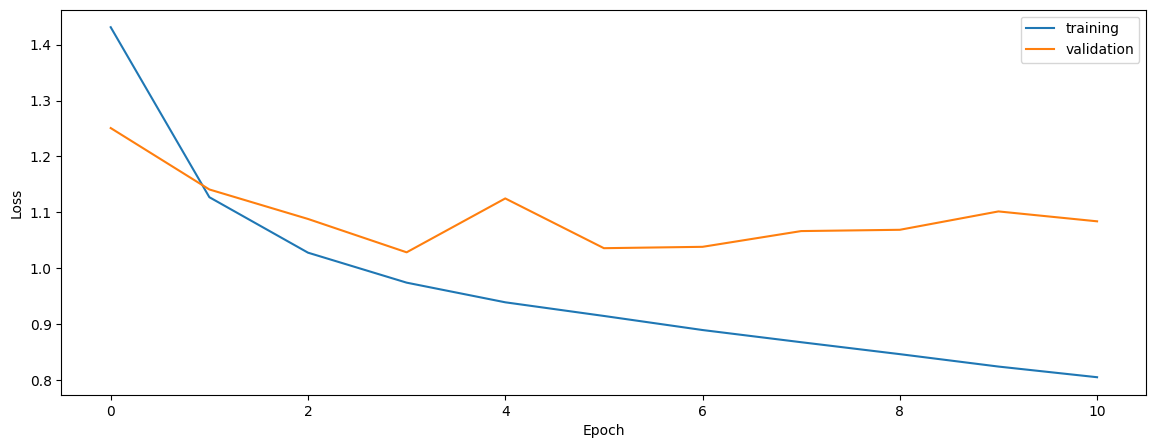

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6298604931793004
0.6073772892510725
0.595435092724679


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5681755266560194
0.5888285283993115
0.5246062562715413


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5695847652515439
0.581252062933216
0.5342997915482282


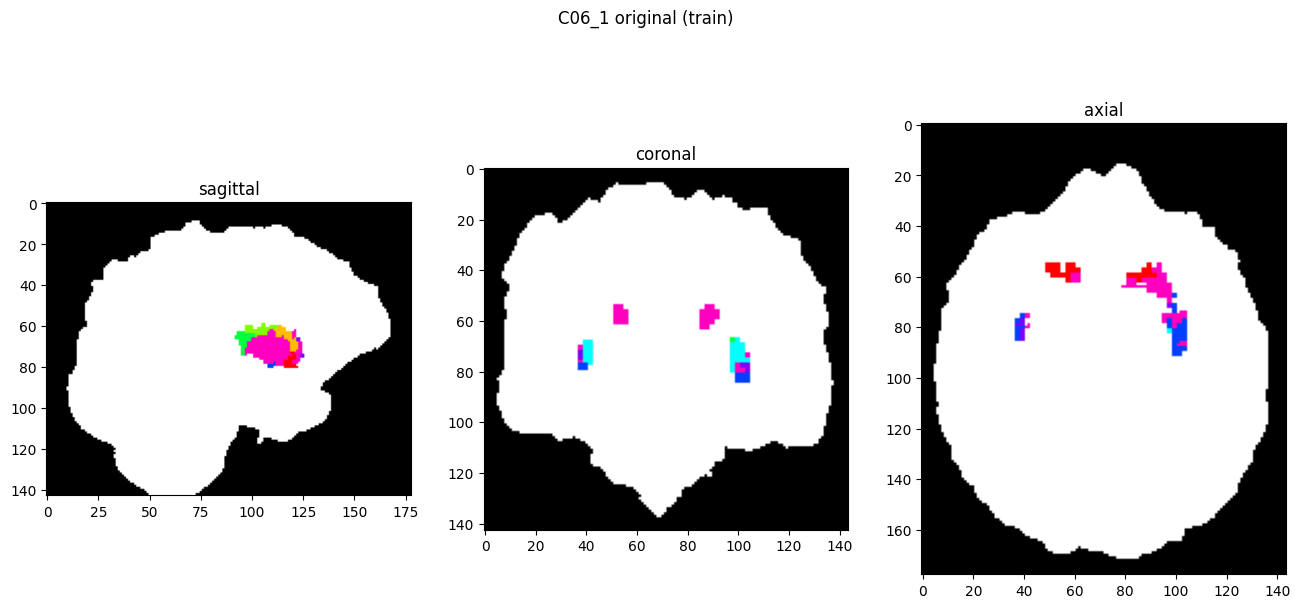

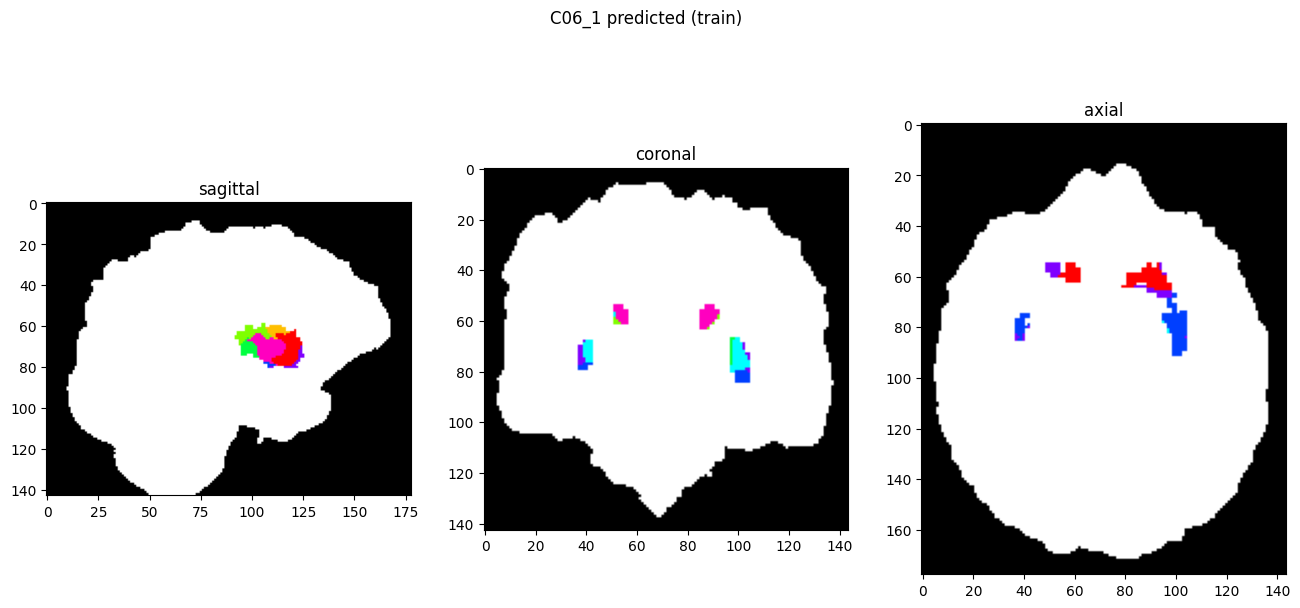

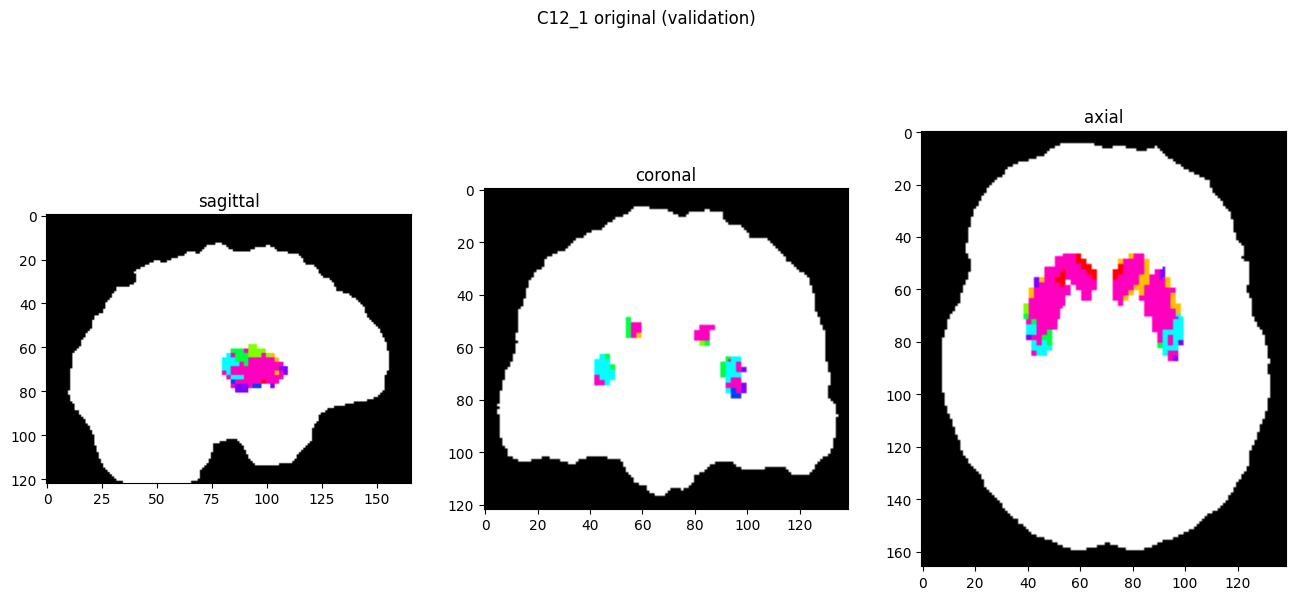

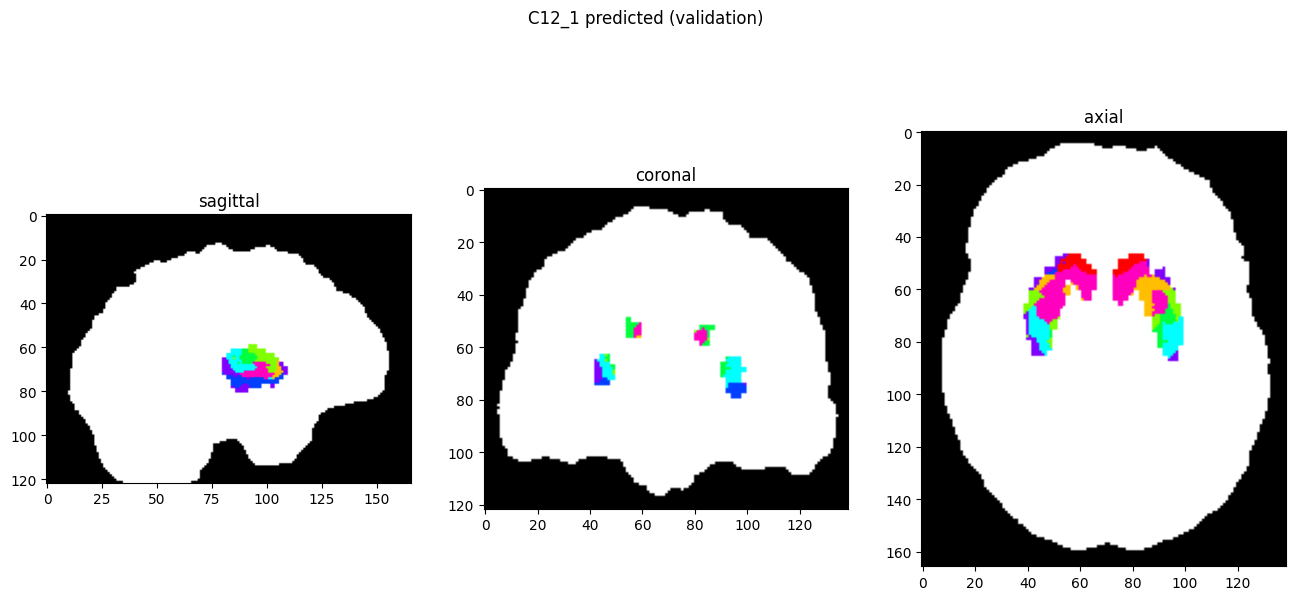

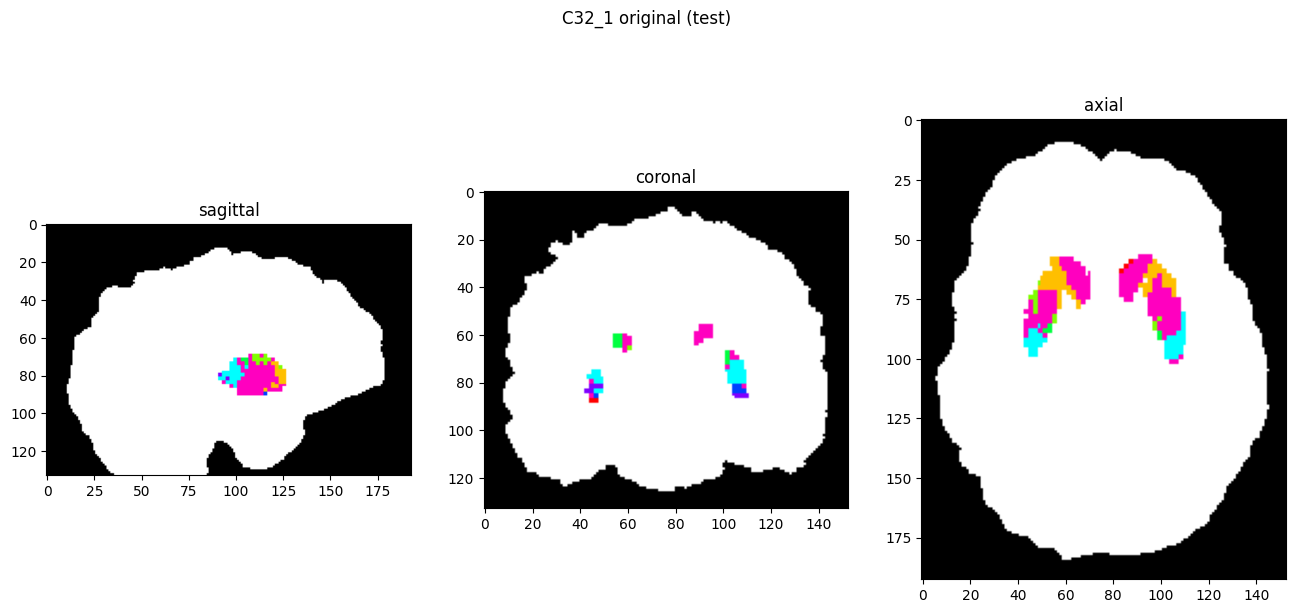

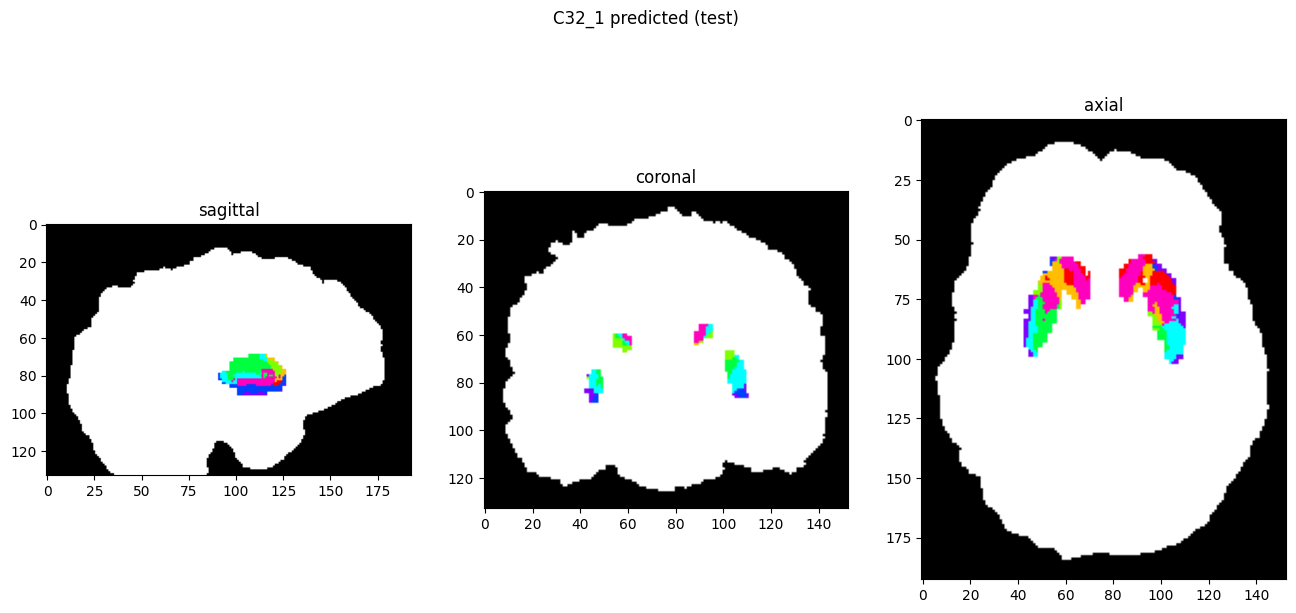

In [10]:
showResults(model, gen, threshold=0)